# Converting Pre-trained Models from Tensorflow to ONNX

[**MODEL ZOO**](https://modelzoo.co/)

Tensorflow has a large selection of pre-trained ssd models in its [object detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).

ONNX has its [own model zoo](https://github.com/winnerineast/models-onnx)

This tutorial shows how to convert them to ONNX and run them under [onnxruntime](https://github.com/microsoft/onnxruntime).


We use [ssd_mobilenet_v1_coco](http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz) as example in this tutorial. Other models should work as well.

ONNX has support for various ops needed for SSD models since opset-10 so you'll need to use onnx-1.5 or better and a runtime that supports opset-10.

In [1]:
%pip install --upgrade ipymagic -q
#import ipymagic
%load_ext ipymagic

%python --version

Note: you may need to restart the kernel to use updated packages.
Python 3.7.7


In [2]:
import os
import sys
from glob import glob

import numpy as np
import tensorflow as tf
import onnx
import tf2onnx
import onnxmltools
import onnxruntime

## Base Environment
Before we start, lets setup some variables where to find things.

In [3]:
print(f"""
For this tutorial use used the following versions:

python      : {sys.version.split(' ')[0]}
numpy       : {np.__version__}
tensorflow  : {tf.__version__}
onnx        : {onnx.__version__}
tf2onnx     : {tf2onnx.__version__}
onnxmltools : {onnxmltools.__version__}
onnxruntime : {onnxruntime.__version__}
""")


For this tutorial use used the following versions:

python      : 3.7.7
numpy       : 1.16.0
tensorflow  : 1.15.2
onnx        : 1.6.0
tf2onnx     : 1.5.6
onnxmltools : 1.6.1
onnxruntime : 1.1.1



In [4]:
# For onnx build
!cmake --version

cmake version 3.14.0

CMake suite maintained and supported by Kitware (kitware.com/cmake).


In [5]:
os.environ

environ{'PATH': '/opt/conda/envs/onnx-tf1-15/bin:/opt/conda/bin:/opt/conda/bin:/opt/conda/sbin:/opt/conda/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin',
        'HOSTNAME': '421dbd2efbbe',
        'TERM': 'xterm-color',
        'CONDA_PATH': '/opt/conda',
        'JUPYTER_CONFIG_DIR': '/opt/conda/etc/jupyter',
        'JUPYTER_DATA_DIR': '/opt/conda/share/jupyter',
        'JAVA_HOME': '/usr/lib/jvm/default-java',
        'WORKDIR': '/workspace',
        'HOME': '/root',
        'LC_CTYPE': 'C.UTF-8',
        'KERNEL_LAUNCH_TIMEOUT': '40',
        'PYTHONPATH': '/opt/conda/envs/onnx-tf1-15/bin/python',
        'JPY_PARENT_PID': '1',
        'CLICOLOR': '1',
        'PAGER': 'cat',
        'GIT_PAGER': 'cat',
        'MPLBACKEND': 'module://ipykernel.pylab.backend_inline'}

In [6]:
ROOT = os.environ['WORKDIR']  # '/workspace'
WORK = os.path.join(ROOT, "trained_models")
os.environ['WORK'] = WORK

os.makedirs(WORK, exist_ok=True)

# Enforce `tf2onnx` to CPU
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

## Download a pre-trained Model

- ~~ResNetV1~~ (Old Format)
  - Name: `resnet_v1_50_2016_08_28`
  - URL : <http://download.tensorflow.org/models/resnet_v1_50_2016_08_28.tar.gz>

- ~~ResNetV2~~ (Old Format)
  - Name: `resnet_v2_50_2017_04_14`
  - URL : <http://download.tensorflow.org/models/resnet_v2_50_2017_04_14.tar.gz>

- **SSDMobileNetV1** ()(Multi-Outputs)
  - Name: `ssd_mobilenet_v1_coco_2018_01_28`
  - URL : <http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz>

##### ~~Use `ResNetV1`~~

In [164]:
MODEL = "resnet_v1_50_2016_08_28"

os.environ['MODEL'] = MODEL
MODEL_PATH = os.path.join(WORK, MODEL)
os.environ['MODEL_PATH'] = MODEL_PATH

In [166]:
%%bash

echo -e "model: '$MODEL'\n"
mkdir -p $MODEL_PATH
echo -e "MODEL_PATH: '$MODEL_PATH'\n"
curl -fsSL http://download.tensorflow.org/models/$MODEL.tar.gz | tar -zxvf - -C $WORK/$MODEL
# wget http://download.tensorflow.org/models/resnet_v1_50_2016_08_28.tar.gz -P $WORK -c

model: 'resnet_v1_50_2016_08_28'

MODEL_PATH: '/workspace/trained_models/resnet_v1_50_2016_08_28'

resnet_v1_50.ckpt


In [167]:
!tree $MODEL_PATH

/workspace/trained_models/resnet_v1_50_2016_08_28
└── resnet_v1_50.ckpt

0 directories, 1 file


##### ~~Use `ResNetV2`~~

In [168]:
MODEL = "resnet_v2_50_2017_04_14"

os.environ['MODEL'] = MODEL
MODEL_PATH = os.path.join(WORK, MODEL)
os.environ['MODEL_PATH'] = MODEL_PATH

In [169]:
%%bash

echo -e "model: '$MODEL'\n"
mkdir -p $MODEL_PATH
echo -e "MODEL_PATH: '$MODEL_PATH'\n"
curl -fsSL http://download.tensorflow.org/models/$MODEL.tar.gz | tar -zxvf - -C $WORK/$MODEL
# wget http://download.tensorflow.org/models/resnet_v1_50_2016_08_28.tar.gz -P $WORK -c

model: 'resnet_v2_50_2017_04_14'

MODEL_PATH: '/workspace/trained_models/resnet_v2_50_2017_04_14'

resnet_v2_50.ckpt
train.graph
eval.graph


In [170]:
!tree $MODEL_PATH

/workspace/trained_models/resnet_v2_50_2017_04_14
├── eval.graph
├── resnet_v2_50.ckpt
└── train.graph

0 directories, 3 files


##### Use `SSDMobileNetV1`

In [25]:
MODEL = "ssd_mobilenet_v1_coco_2018_01_28"

os.environ['MODEL'] = MODEL
MODEL_PATH = os.path.join(WORK, MODEL)
os.environ['MODEL_PATH'] = MODEL_PATH

In [39]:
%%bash

echo -e "model: '$MODEL'\n"
mkdir -p $MODEL_PATH
echo -e "MODEL_PATH: '$MODEL_PATH'\n"
curl -fsSL http://download.tensorflow.org/models/object_detection/$MODEL.tar.gz | tar zxvf - -C $WORK

model: 'ssd_mobilenet_v1_coco_2018_01_28'

MODEL_PATH: '/workspace/trained_models/ssd_mobilenet_v1_coco_2018_01_28'

ssd_mobilenet_v1_coco_2018_01_28/
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.index
ssd_mobilenet_v1_coco_2018_01_28/checkpoint
ssd_mobilenet_v1_coco_2018_01_28/pipeline.config
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.meta
ssd_mobilenet_v1_coco_2018_01_28/saved_model/
ssd_mobilenet_v1_coco_2018_01_28/saved_model/saved_model.pb
ssd_mobilenet_v1_coco_2018_01_28/saved_model/variables/
ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb


In [30]:
!tree $MODEL_PATH

/workspace/trained_models/ssd_mobilenet_v1_coco_2018_01_28
├── checkpoint
├── frozen_inference_graph.pb
├── model.ckpt.data-00000-of-00001
├── model.ckpt.index
├── model.ckpt.meta
├── pipeline.config
└── saved_model
    ├── saved_model.pb
    └── variables

2 directories, 7 files


## Convert the model to ONNX

Above you can see that the model comes as a frozen graph 'frozen_inference_graph.pb' and also as a saved_model. 
Both can be converted to ONNX. We want to show how to convert both formats. 

In both cases make sure you use the option ```--opset 10``` and ```--fold_const```.
The first will enable opset-10 and the second will help the converter with optimizations of transposes.

A look at the model shows inputs and outptus of this model:


CLI Reference:
```bash
python -m tf2onnx.convert
    --saved-model SOURCE_SAVED_MODEL_PATH |
    --checkpoint SOURCE_CHECKPOINT_METAFILE_PATH |
    --input | --graphdef SOURCE_GRAPHDEF_PB
    --output TARGET_ONNX_MODEL
    [--inputs GRAPH_INPUTS]
    [--outputs GRAPH_OUTPUTS]
    [--inputs-as-nchw inputs_provided_as_nchw]
    [--opset OPSET]
    [--target TARGET]
    [--custom-ops list-of-custom-ops]
    [--fold_const]
    [--continue_on_error]
    [--verbose]
```

> `--fold_const`  
> When set, TensorFlow fold_constants transformation is applied before conversion. This benefits features including Transpose optimization (e.g. Transpose operations introduced during tf-graph-to-onnx-graph conversion will be removed), and RNN unit conversion (for example LSTM). Older TensorFlow version might run into issues with this option depending on the model.

### `tf-native`

#### `SavedModel`

##### Use Sample Model

In [25]:
MODEL = "ssd_mobilenet_v1_coco_2018_01_28"

os.environ['MODEL'] = MODEL
MODEL_PATH = os.path.join(WORK, MODEL)
os.environ['MODEL_PATH'] = MODEL_PATH

In [22]:
!which saved_model_cli

/opt/conda/envs/onnx-tf1-15/bin/saved_model_cli


In [118]:
!saved_model_cli show \
  --dir $MODEL_PATH/saved_model/ \
  --tag_set serve  \
  --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['inputs'] tensor_info:
      dtype: DT_UINT8
      shape: (-1, -1, -1, 3)
      name: image_tensor:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['detection_boxes'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100, 4)
      name: detection_boxes:0
  outputs['detection_classes'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100)
      name: detection_classes:0
  outputs['detection_scores'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100)
      name: detection_scores:0
  outputs['num_detections'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: num_detections:0
Method name is: tensorflow/serving/predict


The input is a batch of images in ***NHWC*** format and the used data type it uint8.

Lets start with the ```saved_model``` since this is in most cases the best and prefered format to convert from.

In [76]:
%python -m tf2onnx.convert \
    --opset 10 \
    --fold_const \
    --saved-model $MODEL_PATH/saved_model \
    --output $MODEL_PATH/onnx_model/from_saved_model.onnx


2020-04-23 07:44:00,879 - WARNING - From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-04-23 07:44:04,661 - INFO - Using tensorflow=1.15.2, onnx=1.6.0, tf2onnx=1.5.6/80edd7
2020-04-23 07:44:04,661 - INFO - Using opset <onnx, 10>
2020-04-23 07:44:07,399 - WARNING - Cannot infer shape for Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros: Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros:0
2020-04-23 07:44:28,561 - INFO - Optimizing ONNX model
2020-04-23 07:46:37,012 - INFO - After optimization: Add -47 (337->290), Cast -403 (1184->781), Const -1047 (2704->1657), Div -2 (17->15), Gather +7 (554->561), Identity -861 (864->3), Mul -6 (306->300), Reshape -10 (318->308), Shape -1 (112->111), Slice -1 (299->298), Squeeze -10 (671->661), Transpose -98 (292->194), Unsqueeze -1

##### Use Custom Model

In [126]:
MODEL = "custom-fmnist-resnet/test-03"

os.environ['MODEL'] = MODEL
MODEL_PATH = os.path.join(WORK, MODEL)
os.environ['MODEL_PATH'] = MODEL_PATH
#os.environ['MODEL_PATH_TF'] = os.path.join(MODEL_PATH, 'tf', MODEL)
#os.environ['MODEL_PATH_H5'] = os.path.join(MODEL_PATH, 'h5', MODEL)

In [49]:
!tree $MODEL_PATH

/workspace/trained_models/custom-fmnist-resnet/test-03
├── logs
│   ├── train
│   │   ├── events.out.tfevents.1586460083.gke-cml-0409-191154--n1-standard-16-f-37a93aa3-pj96.448.6304.v2
│   │   ├── events.out.tfevents.1586460083.gke-cml-0409-191154--n1-standard-16-f-37a93aa3-xnt7.448.6304.v2
│   │   ├── events.out.tfevents.1586460084.gke-cml-0409-191154--n1-standard-16-f-37a93aa3-txq3.448.6304.v2
│   │   ├── events.out.tfevents.1586460099.gke-cml-0409-191154--n1-standard-8-4d-088ee845-b558.398.6304.v2
│   │   └── events.out.tfevents.1586460109.gke-cml-0409-191154--n1-standard-8-4d-088ee845-7r15.398.6304.v2
│   └── validation
│       ├── events.out.tfevents.1586460139.gke-cml-0409-191154--n1-standard-16-f-37a93aa3-pj96.448.47866.v2
│       ├── events.out.tfevents.1586460139.gke-cml-0409-191154--n1-standard-16-f-37a93aa3-txq3.448.47866.v2
│       ├── events.out.tfevents.1586460139.gke-cml-0409-191154--n1-standard-16-f-37a93aa3-xnt7.448.47866.v2
│       ├── events.out.tfevents.1586460155.g

In [51]:
!saved_model_cli show \
  --dir $MODEL_PATH \
  --tag_set serve  \
  --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['activation_48'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 2048)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [52]:
%python -m tf2onnx.convert \
    --opset 10 \
    --fold_const \
    --saved-model $MODEL_PATH \
    --output $MODEL_PATH/onnx_model/from_saved_model.onnx


2020-04-26 18:22:35,665 - WARNING - From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1365, in _do_call
    return fn(*args)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1350, in _run_fn
    target_list, run_metadata)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1443, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.DataLossError: Checksum does not match: stored 1851677004 vs. calculated on the restored bytes 3745672354
	 [[{{node RestoreV2}}]]

During handling of the above exception, another exception occurred:

Traceback (most rece

<div class="alert alert-block alert-danger">
<b>Error</b> <br>
    
```sh
WARNING:tensorflow:From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-04-26 18:22:35,665 - WARNING - From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1365, in _do_call
    return fn(*args)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1350, in _run_fn
    target_list, run_metadata)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1443, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.DataLossError: Checksum does not match: stored 1851677004 vs. calculated on the restored bytes 3745672354
	 [[{{node RestoreV2}}]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/convert.py", line 161, in <module>
    main()
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/convert.py", line 123, in main
    args.saved_model, args.inputs, args.outputs, args.signature_def)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/loader.py", line 104, in from_saved_model
    meta_graph_def = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], model_path)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/saved_model/loader_impl.py", line 269, in load
    return loader.load(sess, tags, import_scope, **saver_kwargs)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/saved_model/loader_impl.py", line 423, in load
    self.restore_variables(sess, saver, import_scope)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/saved_model/loader_impl.py", line 377, in restore_variables
    saver.restore(sess, self._variables_path)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 1290, in restore
    {self.saver_def.filename_tensor_name: save_path})
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 956, in run
    run_metadata_ptr)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1180, in _run
    feed_dict_tensor, options, run_metadata)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1359, in _do_run
    run_metadata)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1384, in _do_call
    raise type(e)(node_def, op, message)
tensorflow.python.framework.errors_impl.DataLossError: Checksum does not match: stored 1851677004 vs. calculated on the restored bytes 3745672354
	 [[{{node RestoreV2}}]]
```

</div>

: tensorflow.python.framework.errors_impl.DataLossError: Checksum does not match: stored 1851677004 vs. calculated on the restored bytes 3745672354


= 


In [53]:
MODEL = "custom-fmnist-resnet/test-02"

os.environ['MODEL'] = MODEL
MODEL_PATH = os.path.join(WORK, MODEL)
os.environ['MODEL_PATH'] = MODEL_PATH
#os.environ['MODEL_PATH_TF'] = os.path.join(MODEL_PATH, 'tf', MODEL)
#os.environ['MODEL_PATH_H5'] = os.path.join(MODEL_PATH, 'h5', MODEL)

In [54]:
!tree $MODEL_PATH

/workspace/trained_models/custom-fmnist-resnet/test-02
├── logs
│   └── train
│       ├── events.out.tfevents.1586458763.gke-cml-0409-184957--n1-standard-16-f-52fc1d92-tj7x.448.6304.v2
│       ├── events.out.tfevents.1586458769.gke-cml-0409-184957--n1-standard-8-4d-5f422543-vrln.398.6304.v2
│       ├── events.out.tfevents.1586458778.gke-cml-0409-184957--n1-standard-16-f-52fc1d92-vvtc.448.6304.v2
│       ├── events.out.tfevents.1586458779.gke-cml-0409-184957--n1-standard-16-f-52fc1d92-5wbp.448.6304.v2
│       └── events.out.tfevents.1586458801.gke-cml-0409-184957--n1-standard-8-4d-5f422543-c828.398.6304.v2
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00002
    ├── variables.data-00001-of-00002
    ├── variables.index
    ├── variables_temp_8381d2fc7e38478f9c515a518844e8e9
    │   └── part-00000-of-00002.data-00000-of-00001
    └── variables_temp_f9a666b94a58474eb6f4fefdb4ce7175
        └── part-00000-of-00002.data-00000-of-00001.tempstate2295428741106895911

5 direct

In [55]:
!saved_model_cli show \
  --dir $MODEL_PATH \
  --tag_set serve  \
  --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['activation_48'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 2048)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [56]:
%python -m tf2onnx.convert \
    --opset 10 \
    --fold_const \
    --saved-model $MODEL_PATH \
    --output $MODEL_PATH/onnx_model/from_saved_model.onnx


2020-04-26 18:29:00,398 - WARNING - From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-04-26 18:29:04,319 - INFO - Using tensorflow=1.15.2, onnx=1.6.0, tf2onnx=1.5.6/80edd7
2020-04-26 18:29:04,319 - INFO - Using opset <onnx, 10>
2020-04-26 18:29:04,368 - ERROR - pass1 convert failed for name: "StatefulPartitionedCall"
op: "StatefulPartitionedCall"
input: "serving_default_input_1:0"
input: "conv1/kernel"
input: "conv1/bias"
input: "bn_conv1/gamma"
input: "bn_conv1/beta"
input: "bn_conv1/moving_mean"
input: "bn_conv1/moving_variance"
input: "res2a_branch2a/kernel"
input: "res2a_branch2a/bias"
input: "bn2a_branch2a/gamma"
input: "bn2a_branch2a/beta"
input: "bn2a_branch2a/moving_mean"
input: "bn2a_branch2a/moving_variance"
input: "res2a_branch2b/kernel"
input: "res2a_branch2b/bias"
input: "bn2a_branch2b/gamma"
input: "bn2a_branch2b/beta"
in

<div class="alert alert-block alert-danger">
<b>Error</b> <br>
    
```sh
executed in 5.95s, finished 03:29:04 2020-04-27
WARNING:tensorflow:From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-04-26 18:29:00,398 - WARNING - From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-04-26 18:29:04,319 - INFO - Using tensorflow=1.15.2, onnx=1.6.0, tf2onnx=1.5.6/80edd7
2020-04-26 18:29:04,319 - INFO - Using opset <onnx, 10>
2020-04-26 18:29:04,368 - ERROR - pass1 convert failed for name: "StatefulPartitionedCall"
op: "StatefulPartitionedCall"
input: "serving_default_input_1:0"
input: "conv1/kernel"
input: "conv1/bias"
input: "bn_conv1/gamma"
input: "bn_conv1/beta"
    ...
input: "res5c_branch2c/kernel"
input: "res5c_branch2c/bias"
input: "bn5c_branch2c/gamma"
input: "bn5c_branch2c/beta"
input: "bn5c_branch2c/moving_mean"
input: "bn5c_branch2c/moving_variance"
attr {
  key: "Tin"
  value {
    list {
      type: DT_FLOAT
      type: DT_RESOURCE
      type: DT_RESOURCE
      type: DT_RESOURCE
      ...
      type: DT_RESOURCE
      type: DT_RESOURCE
    }
  }
}
attr {
  key: "Tout"
  value {
    list {
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_gradient_op_type"
  value {
    s: "PartitionedCallUnused"
  }
}
attr {
  key: "config"
  value {
    s: ""
  }
}
attr {
  key: "config_proto"
  value {
    s: "\n\007\n\003CPU\020\001\n\007\n\003GPU\020\0012\005*\0010J\0008\001"
  }
}
attr {
  key: "executor_type"
  value {
    s: ""
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_signature_wrapper_621782"
    }
  }
}
, ex=Value "name: "__inference_signature_wrapper_621782"
" is not valid attribute data type.
Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/convert.py", line 161, in <module>
    main()
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/convert.py", line 145, in main
    inputs_as_nchw=args.inputs_as_nchw)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/tfonnx.py", line 497, in process_tf_graph
    onnx_nodes, op_cnt, attr_cnt, output_shapes, dtypes = tensorflow_to_onnx(tf_graph, shape_override)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/tfonnx.py", line 124, in tensorflow_to_onnx
    return tflist_to_onnx(graph.get_operations(), shape_override)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/tfonnx.py", line 111, in tflist_to_onnx
    onnx_node = helper.make_node(node.type, input_names, output_names, name=node.name, **attr)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/onnx/helper.py", line 56, in make_node
    for key, value in sorted(kwargs.items()))
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/onnx/helper.py", line 56, in <genexpr>
    for key, value in sorted(kwargs.items()))
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/onnx/helper.py", line 273, in make_attribute
    'Value "{}" is not valid attribute data type.'.format(value))
ValueError: Value "name: "__inference_signature_wrapper_621782"
" is not valid attribute data type.
MODEL = "custom-fmnist-resnet/test-00"
```

</div>

: ValueError: Value "name: "__inference_signature_wrapper_621782"


= Use `keras2onnx` instead.


In [128]:
loaded_model = tf.keras.models.load_model(f'{MODEL_PATH}')
onnx_model = keras2onnx.convert_keras(loaded_model)

os.makedirs(f'{MODEL_PATH}/onnx_model/', exist_ok=True)
onnx.save_model(onnx_model, f'{MODEL_PATH}/onnx_model/from_frozen_with_keras2onnx.onnx')

DataLossError: Checksum does not match: stored 905872284 vs. calculated on the restored bytes 3742841940

#### `GraphDef`: `Frozen-Graph`

##### Check Model Type

If your model is in `checkpoint` or `graphdef` format and you do not know the input and output nodes of the model, you can use the `summarize_graph` TensorFlow utility. The `summarize_graph` tool does need to be downloaded and built from source. If you have the option of going to your model provider and obtaining the model in `savedmodel` format, then we recommend doing so.

To find the inputs and outputs for the TensorFlow graph the model developer will know or you can consult TensorFlow's `summarize_graph` tool, for example:

```bash
summarize_graph \
    --in_graph=$MODEL_PATH/frozen_inference_graph.pb \
    --print_structure=true
```

##### Use Sample Model

In [142]:
!which summarize_graph

/usr/local/bin/summarize_graph


In [25]:
MODEL = "ssd_mobilenet_v1_coco_2018_01_28"

os.environ['MODEL'] = MODEL
MODEL_PATH = os.path.join(WORK, MODEL)
os.environ['MODEL_PATH'] = MODEL_PATH

In [138]:
!summarize_graph \
    --in_graph=$MODEL_PATH/frozen_inference_graph.pb \
    --print_structure=true

Found 1 possible inputs: (name=image_tensor, type=uint8(4), shape=[?,?,?,3]) 
No variables spotted.
Found 4 possible outputs: (name=detection_boxes, op=Identity) (name=detection_scores, op=Identity) (name=num_detections, op=Identity) (name=detection_classes, op=Identity) 
Found 6818217 (6.82M) const parameters, 0 (0) variable parameters, and 1540 control_edges
Op types used: 1856 Const, 549 Gather, 452 Minimum, 360 Maximum, 305 Reshape, 197 Sub, 185 Cast, 183 Greater, 180 Split, 180 Where, 140 Add, 135 Mul, 121 StridedSlice, 117 Shape, 115 Pack, 108 ConcatV2, 94 Unpack, 93 Slice, 92 ZerosLike, 92 Squeeze, 90 NonMaxSuppressionV2, 35 Relu6, 34 Conv2D, 29 Switch, 28 Identity, 26 Enter, 15 RealDiv, 14 Merge, 13 Tile, 13 DepthwiseConv2dNative, 12 Range, 12 BiasAdd, 11 TensorArrayV3, 9 ExpandDims, 8 NextIteration, 6 TensorArrayWriteV3, 6 TensorArraySizeV3, 6 TensorArrayGatherV3, 6 Exit, 5 TensorArrayScatterV3, 5 TensorArrayReadV3, 4 Fill, 3 Assert, 3 Transpose, 2 LoopCond, 2 Less, 2 Exp, 2 E

In [121]:
%python -m tf2onnx.convert \
    --opset 10 \
    --fold_const \
    --graphdef $MODEL_PATH/frozen_inference_graph.pb \
    --inputs image_tensor:0 \
    --outputs num_detections:0,detection_boxes:0,detection_scores:0,detection_classes:0 \
    --output $MODEL_PATH/onnx_model/model_from_frozen_graph.onnx


2020-04-23 12:39:47,546 - WARNING - From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-04-23 12:39:50,042 - INFO - Using tensorflow=1.15.2, onnx=1.6.0, tf2onnx=1.5.6/80edd7
2020-04-23 12:39:50,042 - INFO - Using opset <onnx, 10>
2020-04-23 12:39:52,871 - WARNING - Cannot infer shape for Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros: Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros:0
2020-04-23 12:40:14,560 - INFO - Optimizing ONNX model
2020-04-23 12:42:25,257 - INFO - After optimization: Add -47 (337->290), Cast -403 (1184->781), Const -1047 (2704->1657), Div -2 (17->15), Gather +7 (554->561), Identity -861 (864->3), Mul -6 (306->300), Reshape -10 (318->308), Shape -1 (112->111), Slice -1 (299->298), Squeeze -10 (671->661), Transpose -98 (292->194), Unsqueeze -1

#### ~~`GraphDef`: Not Frozen~~

##### ~~Case: `custom-fmnist-resnet/test-00`~~

In [7]:
!tree $WORK/custom-fmnist-resnet/test-00

/workspace/trained_models/custom-fmnist-resnet/test-00
├── checkpoint
├── events.out.tfevents.1586410238.gke-cml-0409-052335-df45-n1-highmem-8-b8b17e6c-n79d
├── graph.pbtxt
├── keras
│   ├── checkpoint
│   ├── keras_model.ckpt.data-00000-of-00002
│   ├── keras_model.ckpt.data-00001-of-00002
│   └── keras_model.ckpt.index
├── model.ckpt-93757.data-00000-of-00002
├── model.ckpt-93757.data-00001-of-00002
├── model.ckpt-93757.index
└── model.ckpt-93757.meta

1 directory, 11 files


In [44]:
MODEL = "custom-fmnist-resnet/test-00"

os.environ['MODEL'] = MODEL
MODEL_PATH = os.path.join(WORK, MODEL)
os.environ['MODEL_PATH'] = MODEL_PATH
#os.environ['MODEL_PATH_TF'] = os.path.join(MODEL_PATH, 'tf', MODEL)
#os.environ['MODEL_PATH_H5'] = os.path.join(MODEL_PATH, 'h5', MODEL)

In [9]:
!tree $MODEL_PATH

/workspace/trained_models/custom-fmnist-resnet/test-00
├── checkpoint
├── events.out.tfevents.1586410238.gke-cml-0409-052335-df45-n1-highmem-8-b8b17e6c-n79d
├── graph.pbtxt
├── keras
│   ├── checkpoint
│   ├── keras_model.ckpt.data-00000-of-00002
│   ├── keras_model.ckpt.data-00001-of-00002
│   └── keras_model.ckpt.index
├── model.ckpt-93757.data-00000-of-00002
├── model.ckpt-93757.data-00001-of-00002
├── model.ckpt-93757.index
└── model.ckpt-93757.meta

1 directory, 11 files


In [24]:
!summarize_graph \
    --in_graph=$MODEL_PATH/graph.pbtxt \
    --print_structure=true

No inputs spotted.
No variables spotted.
Found 1360 possible outputs: (name=global_step/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=global_step/add, op=AddV2) (name=MakeIterator, op=MakeIterator) (name=IteratorToStringHandle, op=IteratorToStringHandle) (name=conv1/kernel/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=conv1/kernel/Assign, op=AssignVariableOp) (name=conv1/bias/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=conv1/bias/Assign, op=AssignVariableOp) (name=bn_conv1/gamma/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=bn_conv1/gamma/Assign, op=AssignVariableOp) (name=bn_conv1/beta/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=bn_conv1/beta/Assign, op=AssignVariableOp) (name=bn_conv1/moving_mean/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=bn_conv1/moving_variance/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=bn_conv1/AssignMovingAvg/ReadVariableOp_1, op=ReadVa

<div class="alert alert-block alert-warning">
<b>Error Case</b> <br>
    
```sh
summarize_graph: error while loading shared libraries: libtensorflow_framework.so.2: cannot open shared object file: No such file or directory
```

</div>

: `summarize_graph`, which is a pre-built binary file is located same `bin` in `$PYTHONPATH` by default.(at the same time when `tensorflow` is installed.)


= **_Compile yourself_** with `tensorflow-git` & `bazel`.

```sh
git clone https://github.com/tensorflow/tensorflow $WORKDIR/tensorflow-git && \
cd $WORKDIR/tensorflow-git && \
bazel build tensorflow/tools/graph_transforms:summarize_graph && \
bazel build tensorflow/tools/graph_transforms:transform_graph && \
ln -s $WORKDIR/tensorflow-git/bazel-bin/tensorflow/tools/graph_transforms/summarize_graph \
    /usr/local/bin/summarize_graph && \
ln -s $WORKDIR/tensorflow-git/bazel-bin/tensorflow/tools/graph_transforms/transform_graph \
    /usr/local/bin/transform_graph
```

[ref1: libtensorflow_framework.so No such file or directory](https://github.com/tensorflow/tensorflow/issues/31327)  
[ref2: `libtensorflow_framework` is versioned from now on](https://github.com/tensorflow/tensorflow/issues/27430#issue-428255558)  

In [10]:
!which freeze_graph

/opt/conda/envs/onnx-tf1-15/bin/freeze_graph


In [46]:
%python -m tensorflow.python.tools.freeze_graph \
    --input_graph=$MODEL_PATH/graph.pbtxt \
    --input_binary=false \
    --output_node_names=activation_48 \
    --input_checkpoint=$MODEL_PATH \
    --output_graph=$MODEL_PATH/frozen_graph.pb

Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 491, in <module>
    run_main()
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 487, in run_main
    app.run(main=my_main, argv=[sys.argv[0]] + unparsed)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/absl/app.py", lin

In [17]:
!freeze_graph \
    --input_graph=$MODEL_PATH/graph.pbtxt \
    --input_checkpoint=$MODEL_PATH/model.ckpt-93757 \
    --output_graph=$MODEL_PATH/frozen_graph.pb \
    --output_node_names=activation_48  # include_top=False so not softmaxed

Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/bin/freeze_graph", line 8, in <module>
    sys.exit(run_main())
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 487, in run_main
    app.run(main=my_main, argv=[sys.argv[0]] + unparsed)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 486, in <lambda>
    my_main = lambda unused_args: main(unused_args, flags)
  File "/opt/conda/envs/onnx-tf1-15/lib/py

In [31]:
!freeze_graph \
    --input_graph=$MODEL_PATH/graph.pbtxt \
    --input_binary=false \
    --input_checkpoint=$MODEL_PATH \
    --output_graph=$MODEL_PATH/frozen_graph.pb \
    --output_node_names=activation_48  # include_top=False so not softmaxed

Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/bin/freeze_graph", line 8, in <module>
    sys.exit(run_main())
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 487, in run_main
    app.run(main=my_main, argv=[sys.argv[0]] + unparsed)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 486, in <lambda>
    my_main = lambda unused_args: main(unused_args, flags)
  File "/opt/conda/envs/onnx-tf1-15/lib/py

<div class="alert alert-block alert-danger">
<b>Error Case</b> <br>
    
```bash
Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/bin/freeze_graph", line 8, in <module>
    sys.exit(run_main())
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 487, in run_main
    app.run(main=my_main, argv=[sys.argv[0]] + unparsed)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 486, in <lambda>
    my_main = lambda unused_args: main(unused_args, flags)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 378, in main
    flags.saved_model_tags, checkpoint_version)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 338, in freeze_graph
    input_graph_def = _parse_input_graph_proto(input_graph, input_binary)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 253, in _parse_input_graph_proto
    text_format.Merge(f.read(), input_graph_def)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 702, in Merge
    allow_unknown_field=allow_unknown_field)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 770, in MergeLines
    return parser.MergeLines(lines, message)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 795, in MergeLines
    self._ParseOrMerge(lines, message)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 817, in _ParseOrMerge
    self._MergeField(tokenizer, message)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 942, in _MergeField
    merger(tokenizer, message, field)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 1016, in _MergeMessageField
    self._MergeField(tokenizer, sub_message)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 942, in _MergeField
    merger(tokenizer, message, field)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 1016, in _MergeMessageField
    self._MergeField(tokenizer, sub_message)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 942, in _MergeField
    merger(tokenizer, message, field)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 1016, in _MergeMessageField
    self._MergeField(tokenizer, sub_message)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 942, in _MergeField
    merger(tokenizer, message, field)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 1016, in _MergeMessageField
    self._MergeField(tokenizer, sub_message)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 928, in _MergeField
    tokenizer.Consume(':')
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 1287, in Consume
    if not self.TryConsume(token):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 1274, in TryConsume
    self.NextToken()
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/google/protobuf/text_format.py", line 1524, in NextToken
    match = self._TOKEN.match(self._current_line, self._column)
MemoryError
```

</div>


[ref1: Freeze-graph not working, allocating too much memory for inference](https://github.com/tensorflow/tensorflow/issues/16592)  
[ref2: freeze_graph for inference memory leak](https://github.com/tensorflow/tensorflow/issues/19837)  
[ref3: [TF 2.0] - freeze_graph not working with converted keras to tensorflow serving model](https://github.com/tensorflow/tensorflow/issues/29253)  




```bash
CONTAINER ID        NAME                  CPU %               MEM USAGE / LIMIT     MEM %               NET I/O             BLOCK I/O           PIDS
421dbd2efbbe        confident_blackwell   76.78%              61.26GiB / 62.85GiB   97.47%              38.7MB / 8.62MB     5.01GB / 64.4MB     21
b0b1b76efd26        suspicious_shtern     0.00%               344KiB / 62.85GiB     0.00%               17.5GB / 207MB      4.66MB / 0B         19
bdf1a647146f        admiring_wu           0.82%               3.812MiB / 62.85GiB   0.01%               7.14GB / 18.4GB     1.49GB / 16.5GB     231


```

<div class="alert alert-block alert-warning">
<b>URL:</b> https://github.com/onnx/tensorflow-onnx/blob/master/examples/call_coverter_via_python.py </div>


```py
import tensorflow as tf
import tf2onnx

with tf.Session() as sess:
    x = tf.placeholder(tf.float32, [2, 3], name="input")
    x_ = tf.add(x, x)
    _ = tf.identity(x_, name="output")
    onnx_graph = tf2onnx.tfonnx.process_tf_graph(sess.graph, input_names=["input:0"], output_names=["output:0"])
    model_proto = onnx_graph.make_model("test")
    with open("/tmp/model.onnx", "wb") as f:
        f.write(model_proto.SerializeToString())
```

In [20]:
import tensorflow as tf
from google.protobuf import text_format

# Let's read our pbtxt file into a Graph protobuf
with open(f"{MODEL_PATH}/graph.pbtxt", "r") as f:
    graph_protobuf = text_format.Parse(f.read(), tf.GraphDef())

# Import the graph protobuf into our new graph.
graph_clone = tf.Graph()
with graph_clone.as_default():
    tf.import_graph_def(graph_def=graph_protobuf, name="")

# Display the graph inline.
graph_clone.as_graph_def()

MemoryError: 

`MemoryError`

```bash
CONTAINER ID        NAME                  CPU %               MEM USAGE / LIMIT     MEM %               NET I/O             BLOCK I/O           PIDS
421dbd2efbbe        confident_blackwell   73.95%              59.17GiB / 62.85GiB   94.15%              72.9MB / 8.81MB     6.97GB / 102MB      12
b0b1b76efd26        suspicious_shtern     0.00%               152KiB / 62.85GiB     0.00%               17.5GB / 207MB      8.49MB / 0B         19
bdf1a647146f        admiring_wu           0.47%               3.777MiB / 62.85GiB   0.01%               7.14GB / 18.4GB     1.51GB / 16.5GB     231
```

##### ~~Case: `builtin-image-classification/test-00`~~

In [22]:
!tree /workspace/trained_models/builtin-image-classification/test-00

/workspace/trained_models/builtin-image-classification/test-00
├── checkpoint
├── eval
│   └── events.out.tfevents.1585705139.cmle-training-7294492744756064431
├── events.out.tfevents.1585705094.cmle-training-7294492744756064431
├── events.out.tfevents.1585705132.n-6478d4cb-w-0.v2
├── graph.pbtxt
├── model
├── model.ckpt-0.data-00000-of-00001
├── model.ckpt-0.index
├── model.ckpt-0.meta
├── model.ckpt-1000.data-00000-of-00001
├── model.ckpt-1000.index
└── model.ckpt-1000.meta

2 directories, 11 files


In [25]:
!!summarize_graph \
    --in_graph=/workspace/trained_models/builtin-image-classification/test-00/graph.pbtxt \
    --print_structure=false

['No inputs spotted.',
 'No variables spotted.',
 'Found 1959 possible outputs: (name=global_step/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=global_step/cond/switch_t, op=Identity) (name=global_step/cond/switch_f, op=Identity) (name=global_step/add, op=Add) (name=input_pipeline_task0/MakeIterator, op=MakeIterator) (name=input_pipeline_task0/IteratorToStringHandle, op=IteratorToStringHandle) (name=tpu_estimator/iterations_per_loop/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=tpu_estimator/iterations_per_loop/Read/ReadVariableOp, op=ReadVariableOp) (name=input_pipeline_task0/while/Exit, op=Exit) (name=Identity_1, op=Identity) (name=conv2d/kernel/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=batch_normalization/gamma/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=batch_normalization/beta/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=batch_normalization/moving_mean/IsInitialized/VarIsInitializedOp, op=V

In [27]:
!freeze_graph \
    --input_graph=/workspace/trained_models/builtin-image-classification/test-00/graph.pbtxt \
    --input_checkpoint=/workspace/trained_models/builtin-image-classification/test-00/model.ckpt-1000 \
    --output_graph=/workspace/trained_models/builtin-image-classification/test-00/frozen_graph.pb \
    --output_node_names=output_0  # include_top=False so not softmaxed

Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0426 17:28:15.686885 140270070961984 deprecation.py:323] From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py:127: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
2020-04-26 17:28:17.669242: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-04-26 17:28:17.813549: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 4007945000 Hz
2020-04-26 17:28:17.814827: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557ba1db6130 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-04-26 17:28:17.814885: I tensorflow/compi

<div class="alert alert-block alert-danger">
<b>Error Case</b> <br>
    
```bash
WARNING:tensorflow:From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py:127: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0426 17:28:15.686885 140270070961984 deprecation.py:323] From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py:127: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
2020-04-26 17:28:17.669242: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-04-26 17:28:17.813549: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 4007945000 Hz
2020-04-26 17:28:17.814827: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557ba1db6130 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-04-26 17:28:17.814885: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/bin/freeze_graph", line 8, in <module>
    sys.exit(run_main())
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 487, in run_main
    app.run(main=my_main, argv=[sys.argv[0]] + unparsed)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 486, in <lambda>
    my_main = lambda unused_args: main(unused_args, flags)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 378, in main
    flags.saved_model_tags, checkpoint_version)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 361, in freeze_graph
    checkpoint_version=checkpoint_version)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py", line 190, in freeze_graph_with_def_protos
    var_list=var_list, write_version=checkpoint_version)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 828, in __init__
    self.build()
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 840, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 878, in _build
    build_restore=build_restore)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 482, in _build_internal
    names_to_saveables)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/training/saving/saveable_object_util.py", line 343, in validate_and_slice_inputs
    for converted_saveable_object in saveable_objects_for_op(op, name):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/training/saving/saveable_object_util.py", line 206, in saveable_objects_for_op
    variable, "", name)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/training/saving/saveable_object_util.py", line 83, in __init__
    self.handle_op = var.op.inputs[0]
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 2154, in __getitem__
    return self._inputs[i]
IndexError: list index out of range
```

</div>

: Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA)

[ref1: Freeze-graph not working, allocating too much memory for inference](https://github.com/tensorflow/tensorflow/issues/16592)  
[ref2: freeze_graph for inference memory leak](https://github.com/tensorflow/tensorflow/issues/19837)  
[ref3: [TF 2.0] - freeze_graph not working with converted keras to tensorflow serving model](https://github.com/tensorflow/tensorflow/issues/29253)  




```bash
CONTAINER ID        NAME                  CPU %               MEM USAGE / LIMIT     MEM %               NET I/O             BLOCK I/O           PIDS
421dbd2efbbe        confident_blackwell   76.78%              61.26GiB / 62.85GiB   97.47%              38.7MB / 8.62MB     5.01GB / 64.4MB     21
b0b1b76efd26        suspicious_shtern     0.00%               344KiB / 62.85GiB     0.00%               17.5GB / 207MB      4.66MB / 0B         19
bdf1a647146f        admiring_wu           0.82%               3.812MiB / 62.85GiB   0.01%               7.14GB / 18.4GB     1.49GB / 16.5GB     231


```

#### ~~`Checkpoint`~~

##### Use Custom Model

In [65]:
MODEL = "custom-fmnist-resnet/test-00"

os.environ['MODEL'] = MODEL
MODEL_PATH = os.path.join(WORK, MODEL)
os.environ['MODEL_PATH'] = MODEL_PATH
#os.environ['MODEL_PATH_TF'] = os.path.join(MODEL_PATH, 'tf', MODEL)
#os.environ['MODEL_PATH_H5'] = os.path.join(MODEL_PATH, 'h5', MODEL)

In [66]:
!tree $MODEL_PATH

/workspace/trained_models/custom-fmnist-resnet/test-00
├── checkpoint
├── events.out.tfevents.1586410238.gke-cml-0409-052335-df45-n1-highmem-8-b8b17e6c-n79d
├── graph.pbtxt
├── keras
│   ├── checkpoint
│   ├── keras_model.ckpt.data-00000-of-00002
│   ├── keras_model.ckpt.data-00001-of-00002
│   └── keras_model.ckpt.index
├── model.ckpt-93757.data-00000-of-00002
├── model.ckpt-93757.data-00001-of-00002
├── model.ckpt-93757.index
└── model.ckpt-93757.meta

1 directory, 11 files


In [67]:
!!summarize_graph \
    --in_graph=$MODEL_PATH/graph.pbtxt \
    --print_structure=true

['No inputs spotted.',
 'No variables spotted.',
 'Found 1360 possible outputs: (name=global_step/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=global_step/add, op=AddV2) (name=MakeIterator, op=MakeIterator) (name=IteratorToStringHandle, op=IteratorToStringHandle) (name=conv1/kernel/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=conv1/kernel/Assign, op=AssignVariableOp) (name=conv1/bias/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=conv1/bias/Assign, op=AssignVariableOp) (name=bn_conv1/gamma/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=bn_conv1/gamma/Assign, op=AssignVariableOp) (name=bn_conv1/beta/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=bn_conv1/beta/Assign, op=AssignVariableOp) (name=bn_conv1/moving_mean/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=bn_conv1/moving_variance/IsInitialized/VarIsInitializedOp, op=VarIsInitializedOp) (name=bn_conv1/AssignMovingAvg/ReadVariableOp_1,

In [36]:
%python -m tf2onnx.convert \
    --opset 10 \
    --checkpoint $MODEL_PATH/model.ckpt-93757.meta \
    --inputs image_tensor:0 \
    --outputs activation_48:0 \
    --output $MODEL_PATH/onnx_model/from_checkpoint.onnx


2020-04-26 18:00:05,589 - WARNING - From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1365, in _do_call
    return fn(*args)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1348, in _run_fn
    self._extend_graph()
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1388, in _extend_graph
    tf_session.ExtendSession(self._session)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Cannot assign a device for operation global_step/IsInitialized/VarIsInitializedOp: Could not satisfy explicit device specification '' because the node {{colocation_node global_step/IsIn

<div class="alert alert-block alert-danger">
<b>Error Case</b> <br>
    
```bash
WARNING:tensorflow:From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-04-26 18:00:05,589 - WARNING - From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1365, in _do_call
    return fn(*args)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1348, in _run_fn
    self._extend_graph()
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1388, in _extend_graph
    tf_session.ExtendSession(self._session)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Cannot assign a device for operation global_step/IsInitialized/VarIsInitializedOp: Could not satisfy explicit device specification '' because the node {{colocation_node global_step/IsInitialized/VarIsInitializedOp}} was colocated with a group of nodes that required incompatible device '/job:chief/task:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:XLA_CPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/job:chief/task:0' assigned_device_name_='' resource_device_name_='' supported_device_types_=[CPU, XLA_CPU] possible_devices_=[]
Identity: CPU XLA_CPU 
Switch: CPU XLA_CPU 
VarHandleOp: CPU XLA_CPU 
Const: CPU XLA_CPU 
VarIsInitializedOp: CPU XLA_CPU 
AssignVariableOp: CPU XLA_CPU 
ReadVariableOp: CPU XLA_CPU 
AssignAddVariableOp: CPU XLA_CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  global_step/Initializer/zeros (Const) 
  global_step (VarHandleOp) 
  global_step/IsInitialized/VarIsInitializedOp (VarIsInitializedOp) 
  global_step/Assign (AssignVariableOp) 
  global_step/Read/ReadVariableOp (ReadVariableOp) 
  global_step/VarIsInitializedOp (VarIsInitializedOp) 
  training/Adam/ReadVariableOp (ReadVariableOp) 
  training/Adam/Adam/AssignAddVariableOp (AssignAddVariableOp) 
  training/Adam/Adam/ReadVariableOp (ReadVariableOp) 
  save/AssignVariableOp (AssignVariableOp) 
  report_uninitialized_variables/VarIsInitializedOp (VarIsInitializedOp) 
  report_uninitialized_variables_1/VarIsInitializedOp (VarIsInitializedOp) 
  global_step/cond/global_step/_5 (Switch) 
  global_step/cond/then/_0/Read/ReadVariableOp (ReadVariableOp) /job:chief/task:0
  Func/global_step/cond/then/_0/input/_10 (Identity) 
  Func/global_step/cond/else/_1/input/_15 (Identity) 

	 [[{{node global_step/IsInitialized/VarIsInitializedOp}}]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 1290, in restore
    {self.saver_def.filename_tensor_name: save_path})
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 956, in run
    run_metadata_ptr)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1180, in _run
    feed_dict_tensor, options, run_metadata)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1359, in _do_run
    run_metadata)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1384, in _do_call
    raise type(e)(node_def, op, message)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Cannot assign a device for operation global_step/IsInitialized/VarIsInitializedOp: Could not satisfy explicit device specification '' because the node node global_step/IsInitialized/VarIsInitializedOp (defined at /site-packages/tensorflow_core/python/framework/ops.py:1748) placed on device No device assignments were active during op 'global_step/IsInitialized/VarIsInitializedOp' creation.  was colocated with a group of nodes that required incompatible device '/job:chief/task:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:XLA_CPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/job:chief/task:0' assigned_device_name_='' resource_device_name_='' supported_device_types_=[CPU, XLA_CPU] possible_devices_=[]
Identity: CPU XLA_CPU 
Switch: CPU XLA_CPU 
VarHandleOp: CPU XLA_CPU 
Const: CPU XLA_CPU 
VarIsInitializedOp: CPU XLA_CPU 
AssignVariableOp: CPU XLA_CPU 
ReadVariableOp: CPU XLA_CPU 
AssignAddVariableOp: CPU XLA_CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  global_step/Initializer/zeros (Const) 
  global_step (VarHandleOp) 
  global_step/IsInitialized/VarIsInitializedOp (VarIsInitializedOp) 
  global_step/Assign (AssignVariableOp) 
  global_step/Read/ReadVariableOp (ReadVariableOp) 
  global_step/VarIsInitializedOp (VarIsInitializedOp) 
  training/Adam/ReadVariableOp (ReadVariableOp) 
  training/Adam/Adam/AssignAddVariableOp (AssignAddVariableOp) 
  training/Adam/Adam/ReadVariableOp (ReadVariableOp) 
  save/AssignVariableOp (AssignVariableOp) 
  report_uninitialized_variables/VarIsInitializedOp (VarIsInitializedOp) 
  report_uninitialized_variables_1/VarIsInitializedOp (VarIsInitializedOp) 
  global_step/cond/global_step/_5 (Switch) 
  global_step/cond/then/_0/Read/ReadVariableOp (ReadVariableOp) /job:chief/task:0
  Func/global_step/cond/then/_0/input/_10 (Identity) 
  Func/global_step/cond/else/_1/input/_15 (Identity) 

	 [[node global_step/IsInitialized/VarIsInitializedOp (defined at /site-packages/tensorflow_core/python/framework/ops.py:1748) ]]Additional information about colocations:No node-device colocations were active during op 'global_step/IsInitialized/VarIsInitializedOp' creation.
No device assignments were active during op 'global_step/IsInitialized/VarIsInitializedOp' creation.

Original stack trace for 'global_step/IsInitialized/VarIsInitializedOp':
  File "/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/site-packages/tf2onnx/convert.py", line 161, in <module>
    main()
  File "/site-packages/tf2onnx/convert.py", line 119, in main
    graph_def, inputs, outputs = loader.from_checkpoint(args.checkpoint, args.inputs, args.outputs)
  File "/site-packages/tf2onnx/loader.py", line 76, in from_checkpoint
    saver = tf.train.import_meta_graph(model_path, clear_devices=True)
  File "/site-packages/tensorflow_core/python/training/saver.py", line 1453, in import_meta_graph
    **kwargs)[0]
  File "/site-packages/tensorflow_core/python/training/saver.py", line 1477, in _import_meta_graph_with_return_elements
    **kwargs))
  File "/site-packages/tensorflow_core/python/framework/meta_graph.py", line 809, in import_scoped_meta_graph_with_return_elements
    return_elements=return_elements)
  File "/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/site-packages/tensorflow_core/python/framework/importer.py", line 405, in import_graph_def
    producer_op_list=producer_op_list)
  File "/site-packages/tensorflow_core/python/framework/importer.py", line 517, in _import_graph_def_internal
    _ProcessNewOps(graph)
  File "/site-packages/tensorflow_core/python/framework/importer.py", line 243, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "/site-packages/tensorflow_core/python/framework/ops.py", line 3561, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "/site-packages/tensorflow_core/python/framework/ops.py", line 3561, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "/site-packages/tensorflow_core/python/framework/ops.py", line 3451, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/convert.py", line 161, in <module>
    main()
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/convert.py", line 119, in main
    graph_def, inputs, outputs = loader.from_checkpoint(args.checkpoint, args.inputs, args.outputs)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/loader.py", line 79, in from_checkpoint
    saver.restore(sess, model_path[:-5])
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 1326, in restore
    err, "a mismatch between the current graph and the graph")
tensorflow.python.framework.errors_impl.InvalidArgumentError: Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Cannot assign a device for operation global_step/IsInitialized/VarIsInitializedOp: Could not satisfy explicit device specification '' because the node node global_step/IsInitialized/VarIsInitializedOp (defined at /site-packages/tensorflow_core/python/framework/ops.py:1748) placed on device No device assignments were active during op 'global_step/IsInitialized/VarIsInitializedOp' creation.  was colocated with a group of nodes that required incompatible device '/job:chief/task:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:XLA_CPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/job:chief/task:0' assigned_device_name_='' resource_device_name_='' supported_device_types_=[CPU, XLA_CPU] possible_devices_=[]
Identity: CPU XLA_CPU 
Switch: CPU XLA_CPU 
VarHandleOp: CPU XLA_CPU 
Const: CPU XLA_CPU 
VarIsInitializedOp: CPU XLA_CPU 
AssignVariableOp: CPU XLA_CPU 
ReadVariableOp: CPU XLA_CPU 
AssignAddVariableOp: CPU XLA_CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  global_step/Initializer/zeros (Const) 
  global_step (VarHandleOp) 
  global_step/IsInitialized/VarIsInitializedOp (VarIsInitializedOp) 
  global_step/Assign (AssignVariableOp) 
  global_step/Read/ReadVariableOp (ReadVariableOp) 
  global_step/VarIsInitializedOp (VarIsInitializedOp) 
  training/Adam/ReadVariableOp (ReadVariableOp) 
  training/Adam/Adam/AssignAddVariableOp (AssignAddVariableOp) 
  training/Adam/Adam/ReadVariableOp (ReadVariableOp) 
  save/AssignVariableOp (AssignVariableOp) 
  report_uninitialized_variables/VarIsInitializedOp (VarIsInitializedOp) 
  report_uninitialized_variables_1/VarIsInitializedOp (VarIsInitializedOp) 
  global_step/cond/global_step/_5 (Switch) 
  global_step/cond/then/_0/Read/ReadVariableOp (ReadVariableOp) /job:chief/task:0
  Func/global_step/cond/then/_0/input/_10 (Identity) 
  Func/global_step/cond/else/_1/input/_15 (Identity) 

	 [[node global_step/IsInitialized/VarIsInitializedOp (defined at /site-packages/tensorflow_core/python/framework/ops.py:1748) ]]Additional information about colocations:No node-device colocations were active during op 'global_step/IsInitialized/VarIsInitializedOp' creation.
No device assignments were active during op 'global_step/IsInitialized/VarIsInitializedOp' creation.

Original stack trace for 'global_step/IsInitialized/VarIsInitializedOp':
  File "/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/site-packages/tf2onnx/convert.py", line 161, in <module>
    main()
  File "/site-packages/tf2onnx/convert.py", line 119, in main
    graph_def, inputs, outputs = loader.from_checkpoint(args.checkpoint, args.inputs, args.outputs)
  File "/site-packages/tf2onnx/loader.py", line 76, in from_checkpoint
    saver = tf.train.import_meta_graph(model_path, clear_devices=True)
  File "/site-packages/tensorflow_core/python/training/saver.py", line 1453, in import_meta_graph
    **kwargs)[0]
  File "/site-packages/tensorflow_core/python/training/saver.py", line 1477, in _import_meta_graph_with_return_elements
    **kwargs))
  File "/site-packages/tensorflow_core/python/framework/meta_graph.py", line 809, in import_scoped_meta_graph_with_return_elements
    return_elements=return_elements)
  File "/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/site-packages/tensorflow_core/python/framework/importer.py", line 405, in import_graph_def
    producer_op_list=producer_op_list)
  File "/site-packages/tensorflow_core/python/framework/importer.py", line 517, in _import_graph_def_internal
    _ProcessNewOps(graph)
  File "/site-packages/tensorflow_core/python/framework/importer.py", line 243, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "/site-packages/tensorflow_core/python/framework/ops.py", line 3561, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "/site-packages/tensorflow_core/python/framework/ops.py", line 3561, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "/site-packages/tensorflow_core/python/framework/ops.py", line 3451, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()
```

</div>

: It seems to be the device allocation should be the same as the checkpoint.

```sh
tensorflow.python.framework.errors_impl.InvalidArgumentError: Cannot assign a device for operation global_step/IsInitialized/VarIsInitializedOp: Could not satisfy explicit device specification '' because the node {{colocation_node global_step/IsInitialized/VarIsInitializedOp}} was colocated with a group of nodes that required incompatible device '/job:chief/task:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:XLA_CPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/job:chief/task:0' assigned_device_name_='' resource_device_name_='' supported_device_types_=[CPU, XLA_CPU] possible_devices_=[]
Identity: CPU XLA_CPU 
Switch: CPU XLA_CPU 
VarHandleOp: CPU XLA_CPU 
Const: CPU XLA_CPU 
VarIsInitializedOp: CPU XLA_CPU 
AssignVariableOp: CPU XLA_CPU 
ReadVariableOp: CPU XLA_CPU 
AssignAddVariableOp: CPU XLA_CPU 
```


##### Use Sample Model

In [124]:
MODEL = "ssd_mobilenet_v1_coco_2018_01_28"

os.environ['MODEL'] = MODEL
MODEL_PATH = os.path.join(WORK, MODEL)
os.environ['MODEL_PATH'] = MODEL_PATH

In [42]:
!tree $MODEL_PATH

/workspace/trained_models/ssd_mobilenet_v1_coco_2018_01_28
├── checkpoint
├── frozen_inference_graph.pb
├── model.ckpt.data-00000-of-00001
├── model.ckpt.index
├── model.ckpt.meta
├── pipeline.config
└── saved_model
    ├── saved_model.pb
    └── variables

2 directories, 7 files


In [43]:
%python -m tf2onnx.convert \
    --opset 10 \
    --fold_const \
    --checkpoint $MODEL_PATH/model.ckpt.meta \
    --inputs image_tensor:0 \
    --outputs num_detections:0,detection_boxes:0,detection_scores:0,detection_classes:0 \
    --output $MODEL_PATH/onnx_model/from_checkpoint.onnx


2020-04-26 18:09:52,891 - WARNING - From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-04-26 18:09:57,224 - INFO - Using tensorflow=1.15.2, onnx=1.6.0, tf2onnx=1.5.6/80edd7
2020-04-26 18:09:57,225 - INFO - Using opset <onnx, 10>
2020-04-26 18:10:00,154 - WARNING - Cannot infer shape for Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros: Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros:0
Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/convert.py", line 161, in <module>
    main()
  F

<div class="alert alert-block alert-danger">
<b>Error</b> <br>

```sh
WARNING - Cannot infer shape for Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros: Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros:0
Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/convert.py", line 161, in <module>
    main()
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/convert.py", line 145, in main
    inputs_as_nchw=args.inputs_as_nchw)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/tfonnx.py", line 497, in process_tf_graph
    onnx_nodes, op_cnt, attr_cnt, output_shapes, dtypes = tensorflow_to_onnx(tf_graph, shape_override)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/tfonnx.py", line 124, in tensorflow_to_onnx
    return tflist_to_onnx(graph.get_operations(), shape_override)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/tfonnx.py", line 68, in tflist_to_onnx
    dtypes[out.name] = utils.map_tf_dtype(out.dtype)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/utils.py", line 192, in map_tf_dtype
    dtype = TF_TO_ONNX_DTYPE[dtype]
KeyError: tf.float32_ref
```

</div>

One of the first things tf2onnx does is freezing the graph, aka all variables become constant.  
This is needed for onnx since it is a inference graph and there are no variables.  
The type tf.float32_ref is a variable so there must be something in the model that can't be make constant.  
An example would be if you have the keep_prob of a dropout come from a placeholder.

[ref](https://github.com/onnx/tensorflow-onnx/issues/740)

<div class="alert alert-block alert-info">
<b>Tip:</b> One of the first things tf2onnx does is freezing the graph, aka all variables become constant. </div>

```sh
python -m tensorflow.python.tools.freeze_graph \
    --input_graph=my_checkpoint_dir/graphdef.pb \
    --input_binary=true \
    --output_node_names=output \
    --input_checkpoint=my_checkpoint_dir \
    --output_graph=tests/models/fc-layers/frozen.pb
```

In [120]:
# *GraphDef REQUIRED

%python -m tf2onnx.convert \
    --opset 10 \
    --fold_const \
    --checkpoint $MODEL_PATH/model.ckpt.meta \
    --graphdef $MODEL_PATH/frozen_inference_graph.pb \
    --inputs image_tensor:0 \
    --outputs num_detections:0,detection_boxes:0,detection_scores:0,detection_classes:0 \
    --output $MODEL_PATH/onnx_model/from_checkpoint.onnx


2020-04-23 12:39:21,888 - WARNING - From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-04-23 12:39:26,965 - INFO - Using tensorflow=1.15.2, onnx=1.6.0, tf2onnx=1.5.6/80edd7
2020-04-23 12:39:26,966 - INFO - Using opset <onnx, 10>
2020-04-23 12:39:30,013 - WARNING - Cannot infer shape for Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros: Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros:0
Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/convert.py", line 161, in <module>
    main()
  F

In [125]:
# *GraphDef REQUIRED

%python -m tf2onnx.convert \
    --opset 11 \
    --fold_const \
    --checkpoint $MODEL_PATH/model.ckpt.meta \
    --graphdef $MODEL_PATH/frozen_inference_graph.pb \
    --inputs image_tensor:0 \
    --outputs num_detections:0,detection_boxes:0,detection_scores:0,detection_classes:0 \
    --output $MODEL_PATH/onnx_model/from_checkpoint.onnx


2020-04-26 19:30:56,560 - WARNING - From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-04-26 19:31:02,754 - INFO - Using tensorflow=1.15.2, onnx=1.6.0, tf2onnx=1.5.6/80edd7
2020-04-26 19:31:02,754 - INFO - Using opset <onnx, 11>
2020-04-26 19:31:05,835 - WARNING - Cannot infer shape for Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros: Postprocessor/BatchMultiClassNonMaxSuppression/map/while/PadOrClipBoxList/cond/zeros:0
Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/convert.py", line 161, in <module>
    main()
  F

## `tf.keras`

It supports two types(`'pb'`, `'h5'`).
This test is considered `'pb'` only in this case.

[model list](https://github.com/keras-team/keras-applications)

In [96]:
MODEL = "resnet50"

os.environ['MODEL'] = MODEL
MODEL_PATH = os.path.join(WORK, MODEL)
os.environ['MODEL_PATH'] = MODEL_PATH
os.environ['MODEL_PATH_TF'] = MODEL_PATH_TF = os.path.join(MODEL_PATH, 'tf', MODEL)
os.environ['MODEL_PATH_H5'] = MODEL_PATH_H5 = os.path.join(MODEL_PATH, 'h5', MODEL)

In [142]:
resnet50v2 = tf.keras.applications.ResNet50V2()

for _typ in ['tf', 'h5']:
    dirname = os.path.join(MODEL_PATH, _typ)
    os.makedirs(dirname, exist_ok=True)
    filename = os.path.join(dirname, 'MODEL')
    resnet50v2.save(
        filepath=filename if _typ == 'tf' else f'{filename}.h5',
        overwrite=True,
        include_optimizer=True,
        save_format=_typ,  # {'tf', 'h5'}
        signatures=None,
    )

INFO:tensorflow:Assets written to: /workspace/trained_models/embeddings_gpu/tf/MODEL/assets


In [85]:
!tree $MODEL_PATH

/workspace/trained_models/resnet50
├── h5
│   └── resnet50.h5
└── tf
    └── resnet50
        ├── assets
        ├── saved_model.pb
        └── variables
            ├── variables.data-00000-of-00002
            ├── variables.data-00001-of-00002
            └── variables.index

5 directories, 5 files


### `tf`(`=='pb'`)

In [147]:
!tree $MODEL_PATH_TF

/workspace/trained_models/resnet50/tf/resnet50
├── assets
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00002
    ├── variables.data-00001-of-00002
    └── variables.index

2 directories, 4 files


In [86]:
!saved_model_cli show \
  --dir $MODEL_PATH_TF \
  --tag_set serve  \
  --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_8'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_input_8:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['probs'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1000)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [88]:
%python -m tf2onnx.convert \
    --opset 10 \
    --fold_const \
    --saved-model $MODEL_PATH_TF \
    --output $MODEL_PATH_TF/onnx_model/from_saved_model.onnx


2020-04-26 19:04:03,711 - WARNING - From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-04-26 19:04:07,072 - INFO - Using tensorflow=1.15.2, onnx=1.6.0, tf2onnx=1.5.6/80edd7
2020-04-26 19:04:07,072 - INFO - Using opset <onnx, 10>
2020-04-26 19:04:07,114 - ERROR - pass1 convert failed for name: "StatefulPartitionedCall"
op: "StatefulPartitionedCall"
input: "serving_default_input_8:0"
input: "conv1_conv_7/kernel"
input: "conv1_conv_7/bias"
input: "conv2_block1_preact_bn_7/gamma"
input: "conv2_block1_preact_bn_7/beta"
input: "conv2_block1_preact_bn_7/moving_mean"
input: "conv2_block1_preact_bn_7/moving_variance"
input: "conv2_block1_1_conv_7/kernel"
input: "conv2_block1_1_bn_7/gamma"
input: "conv2_block1_1_bn_7/beta"
input: "conv2_block1_1_bn_7/moving_mean"
input: "conv2_block1_1_bn_7/moving_variance"
input: "conv2_block1_2_conv_7/kernel"
i

<div class="alert alert-block alert-danger">
<b>Error</b> <br>
    
```sh
executed in 5.95s, finished 03:29:04 2020-04-27
WARNING:tensorflow:From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-04-26 18:29:00,398 - WARNING - From /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-04-26 18:29:04,319 - INFO - Using tensorflow=1.15.2, onnx=1.6.0, tf2onnx=1.5.6/80edd7
2020-04-26 18:29:04,319 - INFO - Using opset <onnx, 10>
2020-04-26 18:29:04,368 - ERROR - pass1 convert failed for name: "StatefulPartitionedCall"
op: "StatefulPartitionedCall"
input: "serving_default_input_1:0"
input: "conv1/kernel"
input: "conv1/bias"
input: "bn_conv1/gamma"
input: "bn_conv1/beta"
    ...
input: "res5c_branch2c/kernel"
input: "res5c_branch2c/bias"
input: "bn5c_branch2c/gamma"
input: "bn5c_branch2c/beta"
input: "bn5c_branch2c/moving_mean"
input: "bn5c_branch2c/moving_variance"
attr {
  key: "Tin"
  value {
    list {
      type: DT_FLOAT
      type: DT_RESOURCE
      type: DT_RESOURCE
      type: DT_RESOURCE
      ...
      type: DT_RESOURCE
      type: DT_RESOURCE
    }
  }
}
attr {
  key: "Tout"
  value {
    list {
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_gradient_op_type"
  value {
    s: "PartitionedCallUnused"
  }
}
attr {
  key: "config"
  value {
    s: ""
  }
}
attr {
  key: "config_proto"
  value {
    s: "\n\007\n\003CPU\020\001\n\007\n\003GPU\020\0012\005*\0010J\0008\001"
  }
}
attr {
  key: "executor_type"
  value {
    s: ""
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_signature_wrapper_621782"
    }
  }
}
, ex=Value "name: "__inference_signature_wrapper_621782"
" is not valid attribute data type.
Traceback (most recent call last):
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/convert.py", line 161, in <module>
    main()
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/convert.py", line 145, in main
    inputs_as_nchw=args.inputs_as_nchw)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/tfonnx.py", line 497, in process_tf_graph
    onnx_nodes, op_cnt, attr_cnt, output_shapes, dtypes = tensorflow_to_onnx(tf_graph, shape_override)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/tfonnx.py", line 124, in tensorflow_to_onnx
    return tflist_to_onnx(graph.get_operations(), shape_override)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tf2onnx/tfonnx.py", line 111, in tflist_to_onnx
    onnx_node = helper.make_node(node.type, input_names, output_names, name=node.name, **attr)
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/onnx/helper.py", line 56, in make_node
    for key, value in sorted(kwargs.items()))
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/onnx/helper.py", line 56, in <genexpr>
    for key, value in sorted(kwargs.items()))
  File "/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/onnx/helper.py", line 273, in make_attribute
    'Value "{}" is not valid attribute data type.'.format(value))
ValueError: Value "name: "__inference_signature_wrapper_621782"
" is not valid attribute data type.
MODEL = "custom-fmnist-resnet/test-00"
```

</div>

: ValueError: Value "name: "__inference_signature_wrapper_621782"


= Use `keras2onnx` instead.


### Use `keras2onnx` for `tf.keras.application`


> ##### tf.keras v.s. keras.io
Both Keras model types are now supported in the `keras2onnx` converter. If the user's Keras package was installed from `Keras.io`, the converter converts the model as it was created by the `keras.io` package. Otherwise, it will convert it through `tf.keras`.  
If you want to override this behaviour,
**please specify the environment variable `TF_KERAS=1` _before invoking the converter python API_**.

[ref](https://pypi.org/project/keras2onnx)

In [89]:
os.environ['TF_KERAS'] = '1'
import keras2onnx


print(f'keras2onnx: {keras2onnx.__version__}')

keras2onnx: 1.6.1


In [135]:
!tree $MODEL_PATH_TF

/workspace/trained_models/resnet50/tf/resnet50
├── assets
├── onnx_model
│   └── from_frozen_with_keras2onnx.onnx
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00002
    ├── variables.data-00001-of-00002
    └── variables.index

3 directories, 5 files


In [111]:
loaded_resnet50v2 = tf.saved_model.load_v2(f'{MODEL_PATH_TF}', tags=None)

In [117]:
#onnx_model = keras2onnx.convert_keras(loaded_resnet50v2, loaded_resnet50v2.name)
# AttributeError: '_UserObject' object has no attribute 'name'

onnx_model = keras2onnx.convert_keras(loaded_resnet50v2, 'resnet50')

os.makedirs(f'{MODEL_PATH_TF}/onnx_model/', exist_ok=True)
onnx.save_model(onnx_model, f'{MODEL_PATH_TF}/onnx_model/from_frozen_with_keras2onnx.onnx')

AttributeError: '_UserObject' object has no attribute 'outputs'

<div class="alert alert-block alert-danger">
<b>Error</b> <br>
    
```sh
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-106-3fc9bcb4a4be> in <module>
----> 1 onnx_model = keras2onnx.convert_keras(loaded_resnet50v2, resnet50v2.name)
      2 
      3 os.makedirs(f'{MODEL_PATH_TF}/onnx_model/', exist_ok=True)
      4 onnx.save_model(onnx_model, f'{MODEL_PATH_TF}/onnx_model/from_frozen_with_keras2onnx.onnx')

/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/keras2onnx/main.py in convert_keras(model, name, doc_string, target_opset, channel_first_inputs, debug_mode, custom_op_conversions)
     79     name = name or model.name
     80     target_opset = target_opset or _get_maximum_opset_supported()
---> 81     output_names = [n.name for n in model.outputs]
     82 
     83     static_set_ke2onnx_converters(set_converter)

AttributeError: '_UserObject' object has no attribute 'outputs'

```

</div>

: ValueError: Value "name: "__inference_signature_wrapper_621782"


= Use `tf.keras.models.load_model` instead of (`tf.saved_model.load` or `tf.saved_model.load_v2`).
    
[ref1](https://github.com/tensorflow/tensorflow/issues/33870)


In [136]:
os.environ['MODEL_PATH_TF']

'/workspace/trained_models/resnet50/tf/resnet50'

In [118]:
loaded_resnet50v2 = tf.keras.models.load_model(f'{MODEL_PATH_TF}')

In [119]:
onnx_model = keras2onnx.convert_keras(loaded_resnet50v2)

os.makedirs(f'{MODEL_PATH_TF}/onnx_model/', exist_ok=True)
onnx.save_model(onnx_model, f'{MODEL_PATH_TF}/onnx_model/from_frozen_with_keras2onnx.onnx')

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


ValueError: Input 0 of node TFNodes/resnet50v2_2/cond/StatefulPartitionedCall_1/Switch_1 was passed float from TFNodes/conv1_conv_7/kernel_6:0 incompatible with expected resource.

<div class="alert alert-block alert-danger">
<b>Error</b> <br>
    
```sh
---------------------------------------------------------------------------
InvalidArgumentError                      Traceback (most recent call last)
/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/framework/importer.py in _import_graph_def_internal(graph_def, input_map, return_elements, validate_colocation_constraints, name, op_dict, producer_op_list)
    500         results = c_api.TF_GraphImportGraphDefWithResults(
--> 501             graph._c_graph, serialized, options)  # pylint: disable=protected-access
    502         results = c_api_util.ScopedTFImportGraphDefResults(results)

InvalidArgumentError: Input 0 of node TFNodes/resnet50v2_2/cond/StatefulPartitionedCall_1/Switch_1 was passed float from TFNodes/conv1_conv_7/kernel_6:0 incompatible with expected resource.

During handling of the above exception, another exception occurred:

ValueError                                Traceback (most recent call last)
<ipython-input-119-41ad2974ff85> in <module>
----> 1 onnx_model = keras2onnx.convert_keras(loaded_resnet50v2)
      2 
      3 os.makedirs(f'{MODEL_PATH_TF}/onnx_model/', exist_ok=True)
      4 onnx.save_model(onnx_model, f'{MODEL_PATH_TF}/onnx_model/from_frozen_with_keras2onnx.onnx')

/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/keras2onnx/main.py in convert_keras(model, name, doc_string, target_opset, channel_first_inputs, debug_mode, custom_op_conversions)
     90                         custom_op_dict=custom_op_conversions)
     91     topology.debug_mode = debug_mode
---> 92     parse_graph(topology, tf_graph, target_opset, output_names)
     93     topology.compile()
     94 

/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/keras2onnx/parser.py in parse_graph(topo, graph, target_opset, output_names)
    826         topo.raw_model.add_output_name(str_value)
    827 
--> 828     return _parse_graph_core(graph, keras_layer_ts_map, topo, top_level, output_names)

/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/keras2onnx/parser.py in _parse_graph_core(graph, keras_node_dict, topology, top_scope, output_names)
    744             _on_parsing_time_distributed_layer(graph, nodes, layer_key_, model_, varset)
    745         elif layer_key_ is None or get_converter(type(layer_key_)) is None:
--> 746             _on_parsing_tf_subgraph(graph, nodes, varset)
    747         else:
    748             kenode = _find_kenode_by_output_tensor(extract_inbound_nodes(layer_key_), nodes[0].name)

/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/keras2onnx/parser.py in _on_parsing_tf_subgraph(graph, node_list, varset)
    400 
    401     sess = keras.backend.get_session()
--> 402     subgraph, replacement = create_subgraph(graph, node_list, sess, operator.full_name)
    403     setattr(operator, 'subgraph', subgraph)
    404     vars_, ts = _locate_inputs_by_node(node_list, varset)

/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/keras2onnx/subgraph.py in create_subgraph(tf_graph, node_list, sess, dst_scope)
    166     with tf.Graph().as_default() as sub_graph:
    167         im_scope = "" if dst_scope is None else dst_scope
--> 168         tf.import_graph_def(output_graph_def, name=im_scope)
    169         if im_scope:
    170             replacement = {k_: im_scope + '/' + k_ for k_ in replacement}

/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py in new_func(*args, **kwargs)
    505                 'in a future version' if date is None else ('after %s' % date),
    506                 instructions)
--> 507       return func(*args, **kwargs)
    508 
    509     doc = _add_deprecated_arg_notice_to_docstring(

/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/framework/importer.py in import_graph_def(graph_def, input_map, return_elements, name, op_dict, producer_op_list)
    403       name=name,
    404       op_dict=op_dict,
--> 405       producer_op_list=producer_op_list)
    406 
    407 

/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/tensorflow_core/python/framework/importer.py in _import_graph_def_internal(graph_def, input_map, return_elements, validate_colocation_constraints, name, op_dict, producer_op_list)
    503       except errors.InvalidArgumentError as e:
    504         # Convert to ValueError for backwards compatibility.
--> 505         raise ValueError(str(e))
    506 
    507     # Create _DefinedFunctions for any imported functions.

ValueError: Input 0 of node TFNodes/resnet50v2_2/cond/StatefulPartitionedCall_1/Switch_1 was passed float from TFNodes/conv1_conv_7/kernel_6:0 incompatible with expected resource.

```

</div>

: ValueError: Input 0 of node [...] was passed float from [***] incompatible with expected resource.


= 
    
[ref1](https://github.com/onnx/tensorflow-onnx/issues/778)


* Success with `In-Memory Model`

In [120]:
onnx_model = keras2onnx.convert_keras(resnet50v2)

os.makedirs(f'{MODEL_PATH_TF}/onnx_model/', exist_ok=True)
onnx.save_model(onnx_model, f'{MODEL_PATH_TF}/onnx_model/from_frozen_with_keras2onnx.onnx')

---
# Benchmark: `tf`, `tf2onnx`

In [248]:
MODEL = "resnet50"

os.environ['MODEL'] = MODEL
MODEL_PATH = os.path.join(WORK, MODEL)
os.environ['MODEL_PATH'] = MODEL_PATH
os.environ['MODEL_PATH_TF'] = os.path.join(MODEL_PATH, 'tf', MODEL)
os.environ['MODEL_PATH_H5'] = os.path.join(MODEL_PATH, 'h5', MODEL)

In [249]:
!tree $MODEL_PATH

/workspace/trained_models/resnet50
├── h5
│   └── resnet50.h5
├── onnx_model
│   └── from_frozen_with_keras2onnx.onnx
└── tf
    └── resnet50
        ├── assets
        ├── saved_model.pb
        └── variables
            ├── variables.data-00000-of-00002
            ├── variables.data-00001-of-00002
            └── variables.index

6 directories, 6 files


In [260]:
!curl -fsSL http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz | tar zxf -

In [393]:
data_paths = glob("101_ObjectCategories/*[!BACKGROUND_Google]/*.jpg")
print(len(data_paths))
data_paths[:5]

7285


['101_ObjectCategories/revolver/image_0077.jpg',
 '101_ObjectCategories/revolver/image_0053.jpg',
 '101_ObjectCategories/revolver/image_0030.jpg',
 '101_ObjectCategories/revolver/image_0027.jpg',
 '101_ObjectCategories/revolver/image_0070.jpg']

## RUN `tf_model`

In [252]:
os.environ['TF_MODEL_PATH'] = TF_MODEL_PATH = os.path.join(
    os.environ['MODEL_PATH_TF'],
    'saved_model.pb',
)

In [256]:
tf_model = tf.keras.models.load_model(os.environ['MODEL_PATH_TF'])

In [257]:
?tf_model.evaluate

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [327]:
import numpy as np
from PIL import Image, ImageDraw, ImageColor
import math
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

In [403]:
raw_data_paths = glob("101_ObjectCategories/*[!BACKGROUND_Google]/*.jpg")
print(len(raw_data_paths))
raw_data_paths[:5]

7285


['101_ObjectCategories/revolver/image_0077.jpg',
 '101_ObjectCategories/revolver/image_0053.jpg',
 '101_ObjectCategories/revolver/image_0030.jpg',
 '101_ObjectCategories/revolver/image_0027.jpg',
 '101_ObjectCategories/revolver/image_0070.jpg']

In [406]:
def get_proper_image_path(img_path):
    x = Image.open(img_path)
    x = np.asarray(x)
    return img_path if x.ndim > 2 else None

In [420]:
data_paths = list(filter(None, (get_proper_image_path(p) for p in raw_data_paths)))
print(len(data_paths))

7077


In [421]:
def get_image(img_path):
    x = Image.open(img_path)
    x = np.asarray(x)
    # x = preprocess_input(x)
    return x

In [544]:
%pip install --upgrade unipy

Requirement already up-to-date: unipy in /opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages (0.1.27)
     |████████████████████████████████| 8.7 MB 113 kB/s eta 0:00:01
     |████████████████████████████████| 26.5 MB 91 kB/s  eta 0:00:01
     |████████████████████████████████| 98 kB 298 kB/s eta 0:00:01
     |████████████████████████████████| 206 kB 448 kB/s eta 0:00:01
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
     |████████████████████████████████| 215 kB 538 kB/s eta 0:00:01
     |████████████████████████████████| 540 kB 608 kB/s eta 0:00:01
  Using cached google_auth_oauthlib-0.4.1-py2.py3-none-any.whl (18 kB)
     |████████████████████████████████| 987 kB 386 kB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 272 kB/s eta 0:00:01
     |████████████████████████████████| 231 kB 284 kB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 449 kB/s eta 0:00:01
     |██████████████

In [547]:
from unipy.utils.generator import ReusableGenerator, re_generator

In [504]:
def get_prep_image(img_path, target_size=None):
    x = tf.keras.preprocessing.image.load_img(
        img_path,
        grayscale=False,
        color_mode='rgb',  # Image
        target_size=target_size,
        interpolation='nearest',
    )
    x = np.asarray(x)
    x = preprocess_input(x, mode='tf')  # mode: One of "caffe", "tf", "torch"
    x = np.expand_dims(x, axis=0)
    return x

# mode: One of "caffe", "tf" or "torch".
#     - caffe: will convert the images from RGB to BGR,
#         then will zero-center each color channel with
#         respect to the ImageNet dataset,
#         without scaling.
#     - tf: will scale pixels between -1 and 1,
#         sample-wise.
#     - torch: will scale pixels between 0 and 1 and then
#         will normalize each channel with respect to the
#         ImageNet dataset.

In [548]:
data_array_gen = ReusableGenerator(get_image(f) for f in data_paths)
data_prep_gen = ReusableGenerator(get_prep_image(f) for f in data_paths)

In [509]:
#%%timeit
import time


t = time.perf_counter()

pred = tf_model.predict(
    data_prep_gen,
    steps=len(data_paths),
    workers=1,
    max_queue_size=128,  # Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. 
    use_multiprocessing=False,  # Used for generator or keras.utils.Sequence input only.
    verbose=1,
)
print(time.perf_counter() - t)

7077/7077 [==============================] - 401s 57ms/step
400.5974352490157


```sh
CONTAINER ID        NAME                CPU %               MEM USAGE / LIMIT     MEM %               NET I/O             BLOCK I/O           PIDS
bdf1a647146f        admiring_wu         579.78%             28.77GiB / 62.85GiB   45.77%              2.2GB / 717MB       840MB / 2.26GB      227
```

In [515]:
print(type(pred))
print(pred[0].shape)

pred_decoded_tf = decode_predictions(pred)
pred_decoded_tf[-3:]

<class 'numpy.ndarray'>
(1000,)


[[('n02437616', 'llama', 0.15925159),
  ('n02417914', 'ibex', 0.10049338),
  ('n02391049', 'zebra', 0.07378857),
  ('n02423022', 'gazelle', 0.041579306),
  ('n02125311', 'cougar', 0.02804535)],
 [('n02389026', 'sorrel', 0.17463423),
  ('n02391049', 'zebra', 0.06998125),
  ('n02437312', 'Arabian_camel', 0.056545377),
  ('n02417914', 'ibex', 0.051300034),
  ('n02422106', 'hartebeest', 0.03356029)],
 [('n02391049', 'zebra', 0.63725334),
  ('n02389026', 'sorrel', 0.15998408),
  ('n02423022', 'gazelle', 0.0069316197),
  ('n03967562', 'plow', 0.0067086597),
  ('n03538406', 'horse_cart', 0.004334446)]]

## RUN `onnx_model`

In [ ]:
import onnx.onnx_cpp2py_export.optimizer as C

os.environ['ONNX_MODEL_PATH'] = ONNX_MODEL_PATH = os.path.join(
    MODEL_PATH,
    'onnx_model',
    'from_frozen_with_keras2onnx.onnx',
)

# onnx_model = onnx.load(ONNX_MODEL_PATH)
# onnx_model_str = onnx_model.SerializeToString()
# optimized_model_str = C.optimize(onnx_model_str, passes=None)
# onnx_model_optimized = onnx.load_from_string(optimized_model_str)
# onnx_model_optimized = onnx.optimizer.optimize(onnx_model)

In [469]:
#data_array_gen = (get_image(f) for f in data_paths)
data_prep_gen = ReusableGenerator(get_prep_image(f) for f in data_paths)

In [494]:
import onnx
import onnxruntime as rt
import onnx.onnx_cpp2py_export.optimizer as C


class ONNXInference(object):
    def __init__(self, model_path, optimize=False):
        self.model = onnx.load(model_path)
        if optimize:
            onnx_model_str = self.model.SerializeToString()
            optimized_model_str = C.optimize(onnx_model_str, passes=None)
            self.model = onnx.load_from_string(optimized_model_str)

        self._prepare_runtime(model_path)
    
    def _prepare_runtime(self, model_path):
        self.sess = rt.InferenceSession(os.path.join(model_path))
        self.onnx_inputs = [i.name for i in self.sess.get_inputs()]
        self.onnx_outputs = [o.name for o in self.sess.get_outputs()]
        
        print(f'inputs : {self.onnx_inputs}')
        print(f'outputs: {self.onnx_outputs}')
        #self.onnx_model = onnx.load(model_path)
        
    def predict(self, x):
        if len(x) == len(self.onnx_inputs):
            input_dict = {i: x_i for i, x_i in zip(self.onnx_inputs, x)}
            return self.sess.run(self.onnx_outputs, input_dict)
        else:
            raise Exception(f"The given input number '{len(x)}' and onnx model input number should be the same.")

In [495]:
onnx_infe_model = ONNXInference(ONNX_MODEL_PATH)

inputs : ['input_11']
outputs: ['probs']


* Error: `INVALID_ARGUMENT: Invalid rank for input`: expand a rank

In [496]:
data_prep_gen = ReusableGenerator(get_prep_image(f) for f in data_paths)

pred = [onnx_infe_model.predict(img) for img in data_prep_gen]

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Invalid rank for input: input_11 Got: 3 Expected: 4 Please fix either the inputs or the model.

<div class="alert alert-block alert-danger">
<b>Error</b> <br>
    
```sh
inputs : ['input_11']
outputs: ['probs']
(1, 224, 224, 3)
---------------------------------------------------------------------------
InvalidArgument                           Traceback (most recent call last)
<ipython-input-496-55e97e795691> in <module>
      1 data_prep_gen = ((get_prep_image(f) for f in data_paths))
----> 2 pred = [onnx_infe_model.predict(img) for img in data_prep_gen]

<ipython-input-496-55e97e795691> in <listcomp>(.0)
      1 data_prep_gen = ((get_prep_image(f) for f in data_paths))
----> 2 pred = [onnx_infe_model.predict(img) for img in data_prep_gen]

<ipython-input-494-8a5b0484dd1b> in predict(self, x)
     26         if len(x) == len(self.onnx_inputs):
     27             input_dict = {i: x_i for i, x_i in zip(self.onnx_inputs, x)}
---> 28             return self.sess.run(self.onnx_outputs, input_dict)
     29         else:
     30             raise Exception(f"The given input number '{len(x)}' and onnx model input number should be the same.")

/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/onnxruntime/capi/session.py in run(self, output_names, input_feed, run_options)
    140             output_names = [output.name for output in self._outputs_meta]
    141         try:
--> 142             return self._sess.run(output_names, input_feed, run_options)
    143         except C.EPFail as err:
    144             if self._enable_fallback:

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Invalid rank for input: input_11 Got: 3 Expected: 4 Please fix either the inputs or the model.
```

</div>

: ONNX loaded model requires an expanded axis.  

* Error: `INVALID_ARGUMENT: Got invalid dimensions for Input`: ONNX need fixed size

In [499]:
data_prep_gen = ReusableGenerator(np.expand_dims(get_prep_image(f), axis=0) for f in data_paths)

pred = [onnx_infe_model.predict(img) for img in data_prep_gen]

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input_11 for the following indices
 index: 1 Got: 197 Expected: 224
 index: 2 Got: 300 Expected: 224
 Please fix either the inputs or the model.

<div class="alert alert-block alert-danger">
<b>Error</b> <br>
    
```sh
inputs : ['input_11']
outputs: ['probs']
(1, 1, 197, 300, 3)
---------------------------------------------------------------------------
InvalidArgument                           Traceback (most recent call last)
<ipython-input-499-92ec9554f4cf> in <module>
      1 data_prep_gen = (np.expand_dims(get_prep_image(f), axis=0) for f in data_paths)
      2 
----> 3 pred = [onnx_infe_model.predict(img) for img in data_prep_gen]

<ipython-input-499-92ec9554f4cf> in <listcomp>(.0)
      1 data_prep_gen = (np.expand_dims(get_prep_image(f), axis=0) for f in data_paths)
      2 
----> 3 pred = [onnx_infe_model.predict(img) for img in data_prep_gen]

<ipython-input-494-8a5b0484dd1b> in predict(self, x)
     26         if len(x) == len(self.onnx_inputs):
     27             input_dict = {i: x_i for i, x_i in zip(self.onnx_inputs, x)}
---> 28             return self.sess.run(self.onnx_outputs, input_dict)
     29         else:
     30             raise Exception(f"The given input number '{len(x)}' and onnx model input number should be the same.")

/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/onnxruntime/capi/session.py in run(self, output_names, input_feed, run_options)
    140             output_names = [output.name for output in self._outputs_meta]
    141         try:
--> 142             return self._sess.run(output_names, input_feed, run_options)
    143         except C.EPFail as err:
    144             if self._enable_fallback:

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input_11 for the following indices
 index: 1 Got: 197 Expected: 224
 index: 2 Got: 300 Expected: 224
 Please fix either the inputs or the model.
```

</div>

: ONNX loaded model requires a fixed size input.  

[ref1: Common errors with `onnxruntime`](http://www.xavierdupre.fr/app/onnxruntime/helpsphinx/auto_examples/plot_common_errors.html)

In [498]:
def get_prep_image(img_path, target_size=None):
    x = tf.keras.preprocessing.image.load_img(
        img_path,
        grayscale=False,
        color_mode='rgb',
        target_size=target_size,
        interpolation='nearest',
    )
    x = np.asarray(x)
    x = preprocess_input(x, mode='tf')
    x = np.expand_dims(x, axis=0)
    return x

In [539]:
data_prep_fixed_size_gen = ReusableGenerator(get_prep_image(f, target_size=(224, 224)) for f in data_paths)
data_prep_for_onnx_gen = ReusableGenerator(np.expand_dims(l, axis=0) for l in data_prep_fixed_size_gen)

In [540]:
#%%timeit
t = time.perf_counter()

pred = [onnx_infe_model.predict(img)[0] for img in data_prep_for_onnx_gen]
print(time.perf_counter() - t)

280.3277927020099


```sh
CONTAINER ID        NAME                CPU %               MEM USAGE / LIMIT     MEM %               NET I/O             BLOCK I/O           PIDS
bdf1a647146f        admiring_wu         312.80%             28.86GiB / 62.85GiB   45.92%              2.22GB / 726MB      841MB / 2.29GB      232
```

In [541]:
pred_array = np.concatenate(pred)

print(type(pred_array))
print(pred_array[0].shape)

pred_decoded_onnx = decode_predictions(pred_array)
pred_decoded_onnx[-3:]

<class 'numpy.ndarray'>
(1000,)


[[('n02437616', 'llama', 0.43486962),
  ('n01873310', 'platypus', 0.19912402),
  ('n02417914', 'ibex', 0.18232316),
  ('n02326432', 'hare', 0.027106483),
  ('n01877812', 'wallaby', 0.018452054)],
 [('n02389026', 'sorrel', 0.39518663),
  ('n02417914', 'ibex', 0.24218312),
  ('n02422106', 'hartebeest', 0.20695865),
  ('n02437312', 'Arabian_camel', 0.035300635),
  ('n02423022', 'gazelle', 0.027825477)],
 [('n02391049', 'zebra', 0.8434858),
  ('n02389026', 'sorrel', 0.089342676),
  ('n02116738', 'African_hunting_dog', 0.0052763782),
  ('n02091244', 'Ibizan_hound', 0.0048087235),
  ('n02509815', 'lesser_panda', 0.002450595)]]

In [621]:
onnx_infe_model.model.producer_version

'1.6.1'

In [624]:
onnx_infe_model.model.DESCRIPTOR

In [438]:
from onnx import helper, shape_inference


# Apply shape inference on the model
inferred_model = shape_inference.infer_shapes(onnx_model)

# Check the model and print Y's shape information
onnx.checker.check_model(inferred_model)
print('After shape inference, the shape info of Y is:\n{}'.format(inferred_model.graph.value_info))

# Function polish_model runs model checker, optimizer, shape inference engine on the model,
# and also strips the doc_string for you.
polished_model = onnx.utils.polish_model(model)

After shape inference, the shape info of Y is:
[name: "input_11:01_permuted"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "N"
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 224
      }
      dim {
        dim_value: 224
      }
    }
  }
}
, name: "input_11:01_permuted_padded"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "N"
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 230
      }
      dim {
        dim_value: 230
      }
    }
  }
}
, name: "convolution_output50"
type {
  tensor_type {
    elem_type: 1
  }
}
, name: "conv1_conv_10/BiasAdd:0_permuted_padded"
type {
  tensor_type {
    elem_type: 1
  }
}
, name: "pool1_pad_10/Pad:0_pooling0"
type {
  tensor_type {
    elem_type: 1
  }
}
, name: "batch_norm_output_buffer42"
type {
  tensor_type {
    elem_type: 1
  }
}
, name: "conv2_block1_preact_relu_8/Relu:0"
type {
  tensor_type {
    elem_t

## ONNX Runtime Server
*Public Preview*

**Ubuntu 16.04**

1. Build the docker image from the Dockerfile in this repository
  ```bash
  docker build -t {docker_image_name} -f Dockerfile.server .
  ```

2. Run the ONNXRuntime server with the image created in step 1

  ```bash
  docker run -v {localModelAbsoluteFolder}:{dockerModelAbsoluteFolder} -p {your_local_port}:8001 {imageName} --model_path {dockerModelAbsolutePath}
  ```
3. Send HTTP requests to the container running ONNX Runtime Server

  Send HTTP requests to the docker container through the binding local port. Here is the full [usage document](https://github.com/Microsoft/onnxruntime/blob/master/docs/ONNX_Runtime_Server_Usage.md).
  ```bash
  curl  -X POST -d "@request.json" -H "Content-Type: application/json" http://0.0.0.0:{your_local_port}/v1/models/mymodel/versions/3:predict  
  ```

In [553]:
os.environ[]onnxruntime.__version__

'1.1.1'

In [558]:
os.environ['ONNX_MODEL_DIR'] = ONNX_MODEL_DIR = os.path.dirname(os.environ['ONNX_MODEL_PATH'])

In [ ]:
os.environ['ONNX_MODEL_DIR']

In [555]:
os.environ['ONNX_MODEL_PATH'] = f'{MODEL_PATH}/onnx_model/'

'/workspace/trained_models/resnet50/onnx_model/'

In [560]:
!gsutil -m cp -r $ONNX_MODEL_DIR gs://yjkim-outputs/onnx/converted/tfkeras/resnet50/

Copying file:///workspace/trained_models/resnet50/onnx_model/from_frozen_with_keras2onnx.onnx [Content-Type=application/octet-stream]...
| [1/1 files][ 97.8 MiB/ 97.8 MiB] 100% Done   7.1 MiB/s ETA 00:00:00           
Operation completed over 1 objects/97.8 MiB.                                     


```bash
docker run \
    -v "{localModelAbsoluteFolder}:{dockerModelAbsoluteFolder}" \
    -p "{your_local_port}:8001" \
    "{imageName}" \
        --model_path "{dockerModelAbsolutePath}"
```

```bash
docker run \
    -v "/mnt/hdc1/data/git/ai-ml-ops/docker/onnx-containers/onnx-tensorflow/onnxruntime_server:/onnxruntime/model" \
    -p 8001:8001 \
    "mcr.microsoft.com/onnxruntime/server" \
        --model_path "/onnxruntime/model/from_frozen_with_keras2onnx.onnx"
```
or

```bash
docker run \
    -it \
    -v "/mnt/hdc1/data/git/ai-ml-ops/docker/onnx-containers/onnx-tensorflow/onnxruntime_server:/onnxruntime/model" \
    -p 9001:8001 \
    -p 50051:50051 \
    --name "ort" \
    "mcr.microsoft.com/onnxruntime/server" \
        --model_path="/onnxruntime/model/from_frozen_with_keras2onnx.onnx"
```

* `8001: HTTP`
* `50051: gRPC`

or

## HTTP Endpoint

The prediction URL for HTTP endpoint is in this format:

```url
http://<your_ip_address>:<port>/v1/models/<your-model-name>/versions/<your-version>:predict
```

**Note**: Since we currently only support one model, the model name and version can be any string length > 0. In the future, model_names and versions will be verified.

### Request and Response Payload

The request and response need to be a protobuf message. The Protobuf definition can be found [here](../onnxruntime/server/protobuf/predict.proto).

A protobuf message could have two formats: binary and JSON. Usually the binary payload has better latency, in the meanwhile the JSON format is easy for human readability. 

The HTTP request header field `Content-Type` tells the server how to handle the request and thus it is mandatory for all requests. Requests missing `Content-Type` will be rejected as `400 Bad Request`.

* For `"Content-Type: application/json"`, the payload will be deserialized as JSON string in UTF-8 format
* For `"Content-Type: application/vnd.google.protobuf"`, `"Content-Type: application/x-protobuf"` or `"Content-Type: application/octet-stream"`, the payload will be consumed as protobuf message directly.

Clients can control the response type by setting the request with an `Accept` header field and the server will serialize in your desired format. The choices currently available are the same as the `Content-Type` header field. If this field is not set in the request, the server will use the same type as your request.

### Inferencing

To send a request to the server, you can use any tool which supports making HTTP requests. Here is an example using `curl`:

```bash
curl -X POST -d "@predict_request_0.json" -H "Content-Type: application/json" http://127.0.0.1:8001/v1/models/mymodel/versions/3:predict
```

or

```bash
curl -X POST --data-binary "@predict_request_0.pb" -H "Content-Type: application/octet-stream" -H "Foo: 1234"  http://127.0.0.1:8001/v1/models/mymodel/versions/3:predict
```

* HTTP Endpoint

```url
http://<your_ip_address>:<port>/v1/models/<your-model-name>/versions/<your-version>:predict
```

In [571]:
import requests
from assets import onnx_ml_pb2
from assets import predict_pb2

import google.protobuf.json_format as json_format
from google.protobuf.json_format import MessageToJson

* HTTP Endpoint

```url
http://<your_ip_address>:<port>/v1/models/<your-model-name>/versions/<your-version>:predict
```

In [675]:
data_prep_fixed_size_gen = ReusableGenerator(get_prep_image(f, target_size=(224, 224)) for f in data_paths)
data_prep_for_onnx_gen = ReusableGenerator(np.expand_dims(l, axis=0) for l in data_prep_fixed_size_gen)

In [661]:
print(onnx_infe_model.onnx_inputs)
print(onnx_infe_model.onnx_outputs)

['input_11']
['probs']


In [667]:
# Create request message to be sent to the predictor
def request_prediction(img):
    # img = np.transpose(img, [2, 0, 1])
    img = np.expand_dims(img, axis=0)
    
    input_tensor = onnx_ml_pb2.TensorProto()
    input_tensor.dims.extend(img.shape)
    input_tensor.data_type = 1
    input_tensor.raw_data = img.tobytes()
    
    request_message = predict_pb2.PredictRequest()
    request_message.inputs["input_11"].data_type = input_tensor.data_type
    request_message.inputs["input_11"].dims.extend(input_tensor.dims)
    request_message.inputs["input_11"].raw_data = input_tensor.raw_data
    
    # write message data to JSON
    return json_format.MessageToJson(request_message)

(224, 224, 3)


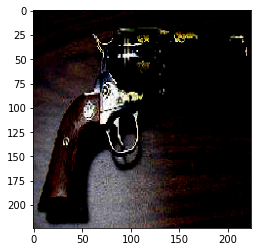

In [655]:
aa = next(data_prep_fixed_size_gen)
#request_msg = request_prediction(aa)

bb = next(data_prep_for_onnx_gen)
#request_msg = request_prediction(bb)

cc = aa[0]
print(cc.shape)
plt.imshow(cc)

In [678]:
predictor_url = 'http://172.17.0.3:8001/v1/models/default/versions/1:predict'

result = []
for _ in data_prep_fixed_size_gen:
    
    img = _[0]
    request_msg = request_prediction(img)
    

    # Call predictor
    request_headers = {
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Host': 'b0b1b76efd26',
    }
    response = requests.post(
        predictor_url,
        headers=request_headers,
        data=request_msg,
    )
    response_parsed = json_format.Parse(response.text, predict_pb2.PredictResponse())
    response_pred = np.frombuffer(response_parsed.outputs['probs'].raw_data, dtype=np.float32)
    response_data = decode_predictions(np.expand_dims(response_pred, axis=0))
    result += [response_data]

result[-3:]

[[[('n02437616', 'llama', 0.43487042),
   ('n01873310', 'platypus', 0.19912325),
   ('n02417914', 'ibex', 0.18232298),
   ('n02326432', 'hare', 0.027106429),
   ('n01877812', 'wallaby', 0.018452052)]],
 [[('n02389026', 'sorrel', 0.3951849),
   ('n02417914', 'ibex', 0.24218436),
   ('n02422106', 'hartebeest', 0.20695913),
   ('n02437312', 'Arabian_camel', 0.035300612),
   ('n02423022', 'gazelle', 0.02782558)]],
 [[('n02391049', 'zebra', 0.84348476),
   ('n02389026', 'sorrel', 0.089343),
   ('n02116738', 'African_hunting_dog', 0.005276417),
   ('n02091244', 'Ibizan_hound', 0.0048087407),
   ('n02509815', 'lesser_panda', 0.0024506175)]]]

```sh
CONTAINER ID        NAME                CPU %               MEM USAGE / LIMIT     MEM %               NET I/O             BLOCK I/O           PIDS
bdf1a647146f        admiring_wu         13.73%              28.91GiB / 62.85GiB   46.00%              6.95GB / 6.25GB     1.44GB / 16.5GB     231
b0b1b76efd26        suspicious_shtern   259.17%             210.5MiB / 62.85GiB   0.33%               5.34GB / 62.1MB     4.1kB / 0B          19
```

##### Build ONNXRuntime Server (`onnxruntime_server`)

```bash
git clone \
    -b rel-1.1.1 \
    --single-branch \
    https://github.com/microsoft/onnxruntime $WORKDIR/onnxruntime-git && \
cd $WORKDIR/onnxruntime-git && \
python ./tools/ci_build/build.py \
    --build_dir ./build \
    --config Release \
    --parallel \
    --cmake_extra_defines ONNXRUNTIME_VERSION=$(cat ./VERSION_NUMBER) && \
cd /"
```

---

# Further Readings

---
## How `tf2onnx` works

The converter needs to take care of a few things:

1. Convert the protobuf format. Since the format is similar this step is straight forward.
2. **TensorFlow types need to be mapped to their ONNX equivalent.**
3. For many ops TensorFlow passes **parameters like shapes as inputs** where ONNX wants to **_see them as attributes_**. Since we use a frozen graph, the converter will fetch the input as constant, converts it to an attribute and remove the original input.
4. TensorFlow in many cases composes ops out of multiple simpler ops. The converter will need to identify the subgraph for such ops, slice the subgraph out and replace it with the ONNX equivalent. This can become fairly complex so we use a graph matching library for it. A good example of this is the tensorflow transpose op.
5. TensorFlow's default data format is `NHWC` where ONNX requires `NCHW`. The converter will insert transpose ops to deal with this.
6. There are **some ops like `relu6`** that are not supported in ONNX but the converter can be composed out of other ONNX ops.
7. ONNX backends are new and their implementations are not complete yet. For some ops the converter generate ops with deal with issues in existing backends.

---
### Step 1 - start with a frozen graph

tf2onnx starts with a frozen graph. This is because of item 3 above.

### Step 2 - 1:1 convertion of the protobuf from tensorflow to onnx

tf2onnx first does a simple conversion from the TensorFlow protobuf format to the ONNX protobuf format without looking at individual ops.
We do this so we can use the ONNX graph as internal representation and write helper functions around it.
The code that does the conversion is in tensorflow_to_onnx(). tensorflow_to_onnx() will return the ONNX graph and a dictionary with shape information from TensorFlow. The shape information is helpful in some cases when processing individual ops.
The ONNX graph is wrapped in a Graph object and nodes in the graph are wrapped in a Node object to allow easier graph manipulations on the graph. All code that deals with nodes and graphs is in graph.py.

### Step 3 - rewrite subgraphs

In the next step we apply graph matching code on the graph to re-write subgraphs for ops like transpose and lstm. For an example looks at rewrite_transpose().

### Step 4 - process individual ops

In the fourth step we look at individual ops that need attention. The dictionary _OPS_MAPPING will map tensorflow op types to a method that is used to process the op. The simplest case is direct_op() where the op can be taken as is. Whenever possible we try to group ops into common processing, for example all ops that require dealing with broadcasting are mapped to broadcast_op(). For an op that composes the tensorflow op from multiple onnx ops, see relu6_op().

### Step 5 - final processing

Once all ops are converted, we need to do a topological sort since ONNX requires it. process_tf_graph() is the method that takes care of all above steps.  

---

---
From: [ONNX_Runtime_Server_Usage](https://raw.githubusercontent.com/microsoft/onnxruntime/master/docs/ONNX_Runtime_Server_Usage.md)

---
## How to Use ONNX Runtime Server for Prediction
ONNX Runtime Server provides an easy way to start an inferencing server for prediction with both HTTP and GRPC endpoints.

### Build the Server

The CLI command to build the server is

Default CPU:

```bash
python3 /onnxruntime/tools/ci_build/build.py --build_dir /onnxruntime/build --config Release --build_server -parallel --cmake_extra_defines ONNXRUNTIME_VERSION=$(cat ./VERSION_NUMBER
```

### Start the Server

The CLI command to start the server is shown below:

```bash
$ ./onnxruntime_server
Version: <Build number>
Commit ID: <The latest commit ID>

the option '--model_path' is required but missing
Allowed options:
  -h [ --help ]                Shows a help message and exits
  --log_level arg (=info)      Logging level. Allowed options (case sensitive):
                               verbose, info, warning, error, fatal
  --model_path arg             Path to ONNX model
  --address arg (=0.0.0.0)     The base HTTP address
  --http_port arg (=8001)      HTTP port to listen to requests
  --num_http_threads arg (=<# of your cpu cores>) Number of http threads
  --grpc_port arg (=50051)     GRPC port to listen to requests
```

**Note**: The only mandatory argument for the program here is `model_path`


* To host an ONNX model as an inferencing server, simply run:

```bash
./onnxruntime_server --model_path /<your>/<model>/<path>
```

### Endpoint

#### HTTP Endpoint

The prediction URL for HTTP endpoint is in this format:

```url
http://<your_ip_address>:<port>/v1/models/<your-model-name>/versions/<your-version>:predict
```

#### GRPC Endpoint

If you prefer using the GRPC endpoint, the protobuf could be found [here](../onnxruntime/server/protobuf/prediction_service.proto). You could generate your client and make a GRPC call to it. To learn more about how to generate the client code and call to the server, please refer to [the tutorials of GRPC](https://grpc.io/docs/tutorials/).


**Note**: Since we currently only support one model, the model name and version can be any string length > 0. In the future, model_names and versions will be verified.

### Request and Response Payload

The request and response need to be a protobuf message. The Protobuf definition can be found [here](../onnxruntime/server/protobuf/predict.proto).

A protobuf message could have two formats: binary and JSON. Usually the binary payload has better latency, in the meanwhile the JSON format is easy for human readability. 

The HTTP request header field `Content-Type` tells the server how to handle the request and thus it is mandatory for all requests. Requests missing `Content-Type` will be rejected as `400 Bad Request`.

* For `"Content-Type: application/json"`, the payload will be deserialized as JSON string in UTF-8 format
* For `"Content-Type: application/vnd.google.protobuf"`, `"Content-Type: application/x-protobuf"` or `"Content-Type: application/octet-stream"`, the payload will be consumed as protobuf message directly.

Clients can control the response type by setting the request with an `Accept` header field and the server will serialize in your desired format. The choices currently available are the same as the `Content-Type` header field. If this field is not set in the request, the server will use the same type as your request.

### Inferencing

To send a request to the server, you can use any tool which supports making HTTP requests. Here is an example using `curl`:

```bash
curl -X POST -d "@predict_request_0.json" -H "Content-Type: application/json" http://127.0.0.1:8001/v1/models/mymodel/versions/3:predict
```

or

```bash
curl -X POST --data-binary "@predict_request_0.pb" -H "Content-Type: application/octet-stream" -H "Foo: 1234"  http://127.0.0.1:8001/v1/models/mymodel/versions/3:predict
```

### Interactive tutorial notebook

A simple Jupyter notebook demonstrating the usage of ONNX Runtime server to host an ONNX model and perform inferencing can be found [here](https://github.com/onnx/tutorials/blob/master/tutorials/OnnxRuntimeServerSSDModel.ipynb).


## Tensorflow Binary Tools for Managing Models

### `saved_model_cli`

`run` BNS or gRPC, `convert` to `TensorRT`

#### `scan`

In [244]:
!saved_model_cli scan -h

usage: saved_model_cli scan [-h] --dir DIR [--tag_set TAG_SET]

Usage example:
To scan for blacklisted ops in SavedModel:
$saved_model_cli scan --dir /tmp/saved_model
To scan a specific MetaGraph, pass in --tag_set

optional arguments:
  -h, --help         show this help message and exit
  --dir DIR          directory containing the SavedModel to execute
  --tag_set TAG_SET  tag-set of graph in SavedModel to scan, separated by ','


#### `run`

In [242]:
!saved_model_cli run -h

usage: saved_model_cli run [-h] --dir DIR --tag_set TAG_SET --signature_def
                           SIGNATURE_DEF_KEY [--inputs INPUTS]
                           [--input_exprs INPUT_EXPRS]
                           [--input_examples INPUT_EXAMPLES] [--outdir OUTDIR]
                           [--overwrite] [--tf_debug] [--worker WORKER]
                           [--init_tpu]

Usage example:
To run input tensors from files through a MetaGraphDef and save the output tensors to files:
$saved_model_cli show --dir /tmp/saved_model --tag_set serve \
   --signature_def serving_default \
   --inputs input1_key=/tmp/124.npz[x],input2_key=/tmp/123.npy \
   --input_exprs 'input3_key=np.ones(2)' \
   --input_examples 'input4_key=[{"id":[26],"weights":[0.5, 0.5]}]' \
   --outdir=/out

For more information about input file format, please see:
https://www.tensorflow.org/guide/saved_model_cli

optional arguments:
  -h, --help            show this help message and exit
  --dir DIR             di

#### `convert`

In [241]:
!saved_model_cli convert -h

usage: saved_model_cli convert [-h] --dir DIR --output_dir OUTPUT_DIR
                               --tag_set TAG_SET
                               {tensorrt} ...

Usage example:
To convert the SavedModel to one that have TensorRT ops:
$saved_model_cli convert \
   --dir /tmp/saved_model \
   --tag_set serve \
   --output_dir /tmp/saved_model_trt \
   tensorrt 

optional arguments:
  -h, --help            show this help message and exit
  --dir DIR             directory containing the SavedModel to convert
  --output_dir OUTPUT_DIR
                        output directory for the converted SavedModel
  --tag_set TAG_SET     tag-set of graph in SavedModel to convert, separated by ','

conversion methods:
  valid conversion methods

  {tensorrt}            the conversion to run with the SavedModel


[Other Tutorials](https://github.com/onnx/tutorials/tree/master/tutorials)